In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
imgs_path = "../src/imgs"

# Helper functions

In [4]:
def combine_datasets(algorithm_name, log_data_path, parameter_group=None, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            if parameter_group:
                simulation = simulation.where(simulation["Parameter Group"] == parameter_group).dropna(how="all")
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            
    
            if parameter_group:
                simulation = simulation.where(simulation["Parameter Group"] == parameter_group).dropna(how="all")
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
        
        
        df["gini_index"] = get_gini_coefficients(df)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.gini_index)
        df["gini_mean"] = mean_f0
        df["gini_min"] = min_f0
        df["gini_max"] = max_f0
        
        df["total_drive_time"] = [sum(x)/(60) for x in df.vehicle_route_time]
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.total_drive_time)
        df["total_drive_time_mean"] = mean_f0
        df["total_drive_time_min"] = min_f0
        df["total_drive_time_max"] = max_f0
        
        df["vehicle_amount"] = [len(x) for x in df.vehicle_route_time]
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.total_drive_time)
        df["vehicle_amount_mean"] = mean_f0
        df["vehicle_amount_min"] = min_f0
        df["vehicle_amount_max"] = max_f0
        
        
        
        
        
    return pd.concat(simulations)

def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points





def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]




def plot_3d_minmax(datapoints, labels, third_axis = "time",marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II\_Multi-obj": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III\_Multi-obj":{"color":"#2ca02c", "marker":"s"}, "IBEA\_Multi-obj":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III\_Multi-obj":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA\_Bi-obj"] = {"color":"#1f77b4", "marker":"o","linestyle":"dotted"}
    marker_kwargs["GA\_Bi-obj"] = {"color":"#e377c2", "marker":"o","linestyle":"dotted"}
    marker_kwargs["NSGA-II\_Bi-obj"] = {"color":"#ff7f0e", "marker":"o","linestyle":"dotted"}
    marker_kwargs["NSGA-III\_Bi-obj"] = {"color":"#2ca02c", "marker":"o","linestyle":"dotted"}
    marker_kwargs["UNSGA-III\_Bi-obj"] = {"color":"#8c564b", "marker":"o","linestyle":"dotted"}
    marker_kwargs["IBEA\_Bi-obj"] = {"color":"#d62728", "marker":"o","linestyle":"dotted"}
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):


        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.total_drive_time_mean/60  , data.total_drive_time_min/60, data.total_drive_time_max/60
        
        
        if third_axis == "time":
            mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
            third_axis_label = ""
        elif third_axis == "gini":
            mean_f2,min_f2,max_f2 = data.gini_mean, data.gini_min, data.gini_max
            
        #print(mean_f1,min_f1,max_f1)
        if "Bi-obj" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k",linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k",linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k",linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
            ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
            
        
        
        
        #ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
        #ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
        #ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
        
        if third_axis == "time":
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        elif third_axis == "gini":
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nGini - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                                 round(min_f1,1),round(mean_f1,1),round(max_f1,1),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        

        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        
        
    gini_lim = ax.get_zlim()[0]     
    for data, label in zip(datapoints, labels):

        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.total_drive_time_mean/60  , data.total_drive_time_min/60, data.total_drive_time_max/60
        
        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=[gini_lim], label='_nolegend_', s=250, **marker_kwargs[label], zorder=2,alpha=0.5)
        
    return fig, ax


def plot_3d_minmax_scaled(datapoints, labels, show_mean_eval=False, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA\_Bi-obj"] = {"color":"#1f77b4", "marker":"o","linestyle":"dotted"}
    marker_kwargs["GA\_Bi-obj"] = {"color":"#e377c2", "marker":"o","linestyle":"dotted"}
    marker_kwargs["NSGA-II\_Bi-obj"] = {"color":"#ff7f0e", "marker":"o","linestyle":"dotted"}
    marker_kwargs["NSGA-III\_Bi-obj"] = {"color":"#2ca02c", "marker":"o","linestyle":"dotted"}
    marker_kwargs["UNSGA-III\_Bi-obj"] = {"color":"#8c564b", "marker":"o","linestyle":"dotted"}
    marker_kwargs["IBEA\_Bi-obj"] = {"color":"#d62728", "marker":"o","linestyle":"dotted"}
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):

        #fuel_consumptions = np.array(data.fuel_consumption_final)#np.array( [x[0] for x in data.fitness_final])
        #drive_times = data.vehicle_route_time
        #compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
        
        if "Bi-obj" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k",linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k",linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k",linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
            ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
            
        
        if show_mean_eval:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}\nMean Evaluations: {}".format(
                                                                                     round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                     round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                     round(min_f2,2),round(mean_f2,2),round(max_f2,2), round(data.num_evaluations))
        else:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                         round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        # ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return fig, ax


In [98]:
from matplotlib.ticker import FormatStrFormatter



def plot_vehicle_drivetimes(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)

    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    max_vehicle_amount = vehicle_amounts[-1]
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean/60,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s \ hours$" % (vehicle_amount, np.round(mean_route_time_sum/60,1)))
    plt.xticks(ticks=range(0,max_vehicle_amount),labels=range(1,max_vehicle_amount+1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.ylabel("Drive Time (Hours)",fontsize=42)
    plt.xlabel("Vehicle nr",fontsize=42)
    plt.legend(fontsize=24)
        
    

In [6]:
def add_minmax_fuel_drivetime_columns(dataframes):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    for dataframe in dataframes:
        datasets = dataframe.dataset.unique()
        for dataset in datasets:
            if not dataset in max_fuel_consumptions.keys():
                max_fuel_consumptions[dataset] = 0
                min_fuel_consumptions[dataset]  = 10e10
                max_drivetimes[dataset]  = 0
                min_drivetimes[dataset]  = 10e10
            
            
            
            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()
            
            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()
            
            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel
                
            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel
                
            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime
                
            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
                
    
    for dataframe in dataframes:
        datasets = dataframe.dataset.unique()
        for dataset in datasets:
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = (dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)

            dataframe['fuel_consumption_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_fuel_consumption_scaled,dataframe.fuel_consumption_final_minmax)
            
            dataframe_longest_drivetime_scaled = (dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
            dataframe['longest_route_time_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_longest_drivetime_scaled,dataframe.longest_route_time_final_minmax)
      
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.fuel_consumption_final_minmax)
        dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
        dataframe["fuel_consumption_final_minmax_min"] = min_f0
        dataframe["fuel_consumption_final_minmax_max"] = max_f0

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.longest_route_time_final_minmax)
        dataframe["longest_route_time_final_minmax_mean"] = mean_f0
        dataframe["longest_route_time_final_minmax_min"] = min_f0
        dataframe["longest_route_time_final_minmax_max"] = max_f0
        

In [7]:
def plot_2d_minmax_scaled(datapoints, labels, show_mean_eval=False, minmax_scale = True,marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Multiobjective":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA\_Bi-obj"] = {"color":"#1f77b4", "marker":"o","linestyle":"dotted"}
    marker_kwargs["GA\_Bi-obj"] = {"color":"#e377c2", "marker":"o","linestyle":"dotted"}
    marker_kwargs["NSGA-II\_Bi-obj"] = {"color":"#ff7f0e", "marker":"o","linestyle":"dotted"}
    marker_kwargs["NSGA-III\_Bi-obj"] = {"color":"#2ca02c", "marker":"o","linestyle":"dotted"}
    marker_kwargs["UNSGA-III\_Bi-obj"] = {"color":"#8c564b", "marker":"o","linestyle":"dotted"}
    marker_kwargs["IBEA\_Bi-obj"] = {"color":"#d62728", "marker":"o","linestyle":"dotted"}

    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        if minmax_scale:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        else:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
            mean_f1,min_f1,max_f1 = data.total_drive_time_mean  , data.total_drive_time_min, data.total_drive_time_max
            
            
            
        if "Bi-obj" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
            
        if minmax_scale:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))
        else:
            


            if show_mean_eval:
                plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                         round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                                         int(round(min_f1,0)),int(round(mean_f1,0)),int(round(max_f1,0)), round(data.num_evaluations))
            else:
                plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                             round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                             int(round(min_f1,0)),int(round(mean_f1,0)),int(round(max_f1,0)))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
    return fig, ax

In [8]:
from sympy import symbols, solve,Eq
def get_pareto_line(algorithms,xlim,ylim):
    best_sol = list(sorted(algorithms,key=lambda x: x.fuel_consumption_final_mean + x.total_drive_time_mean))[0]
    best_obj_sum =  best_sol.fuel_consumption_final+best_sol.total_drive_time_mean#best_sol.objective_sum
    best_obj_x =  best_sol.fuel_consumption_final
    best_obj_y =  best_sol.total_drive_time_mean
    
    x0,x1 = xlim
    y0,y1 = ylim
    test_x = best_obj_sum - y0
    
    k = (best_obj_y-y0)/(best_obj_x-test_x)
    m = best_obj_y- (best_obj_x*k)
    
    point_2_x = symbols('x')
    expr = (point_2_x*k) + m
    sol = solve(expr)
    point_1 = (0,m)
    point_2 = (sol[0],0) 
    return point_1,point_2

In [9]:
import time 
start_time = time.monotonic()
print("NSGA2")
NSGA2_data_evaluation_limited = combine_datasets("NSGA2", "parameter_data/Multi_Objective_Results/",parameter_group=32)
print("NSGA3")
NSGA3_data_evaluation_limited = combine_datasets("NSGA3", "parameter_data/Multi_Objective_Results/",parameter_group=44)
print("UNSGA3")
UNSGA3_data_evaluation_limited = combine_datasets("UNSGA3", "parameter_data/Multi_Objective_Results/",parameter_group=44)
print("IBEA")
IBEA_data_evaluation_limited = combine_datasets("IBEA", "parameter_data/Multi_Objective_Results/",parameter_group=35)

print("Time: ", time.monotonic() - start_time)

NSGA2
NSGA3
UNSGA3
IBEA
Time:  12.395180688999972


# Plot

In [10]:
def get_algorithm_coordinates(algorithms):
    coordinates = [[0,0]]
    
    for algorithm in algorithms:
        coordinates.append([algorithm.fuel_consumption_final,algorithm.total_drive_time])
    return coordinates

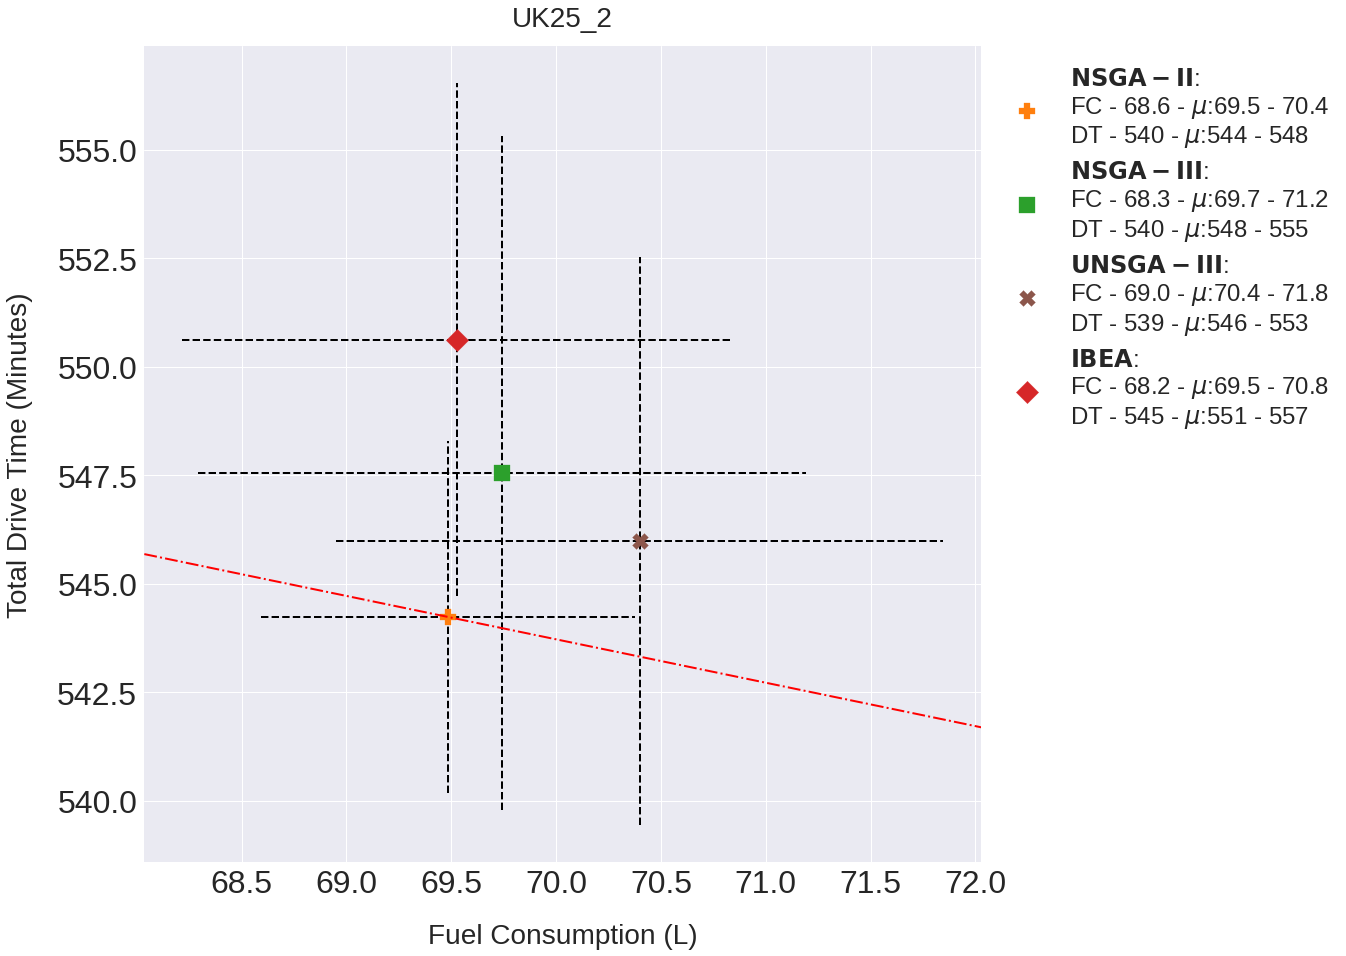

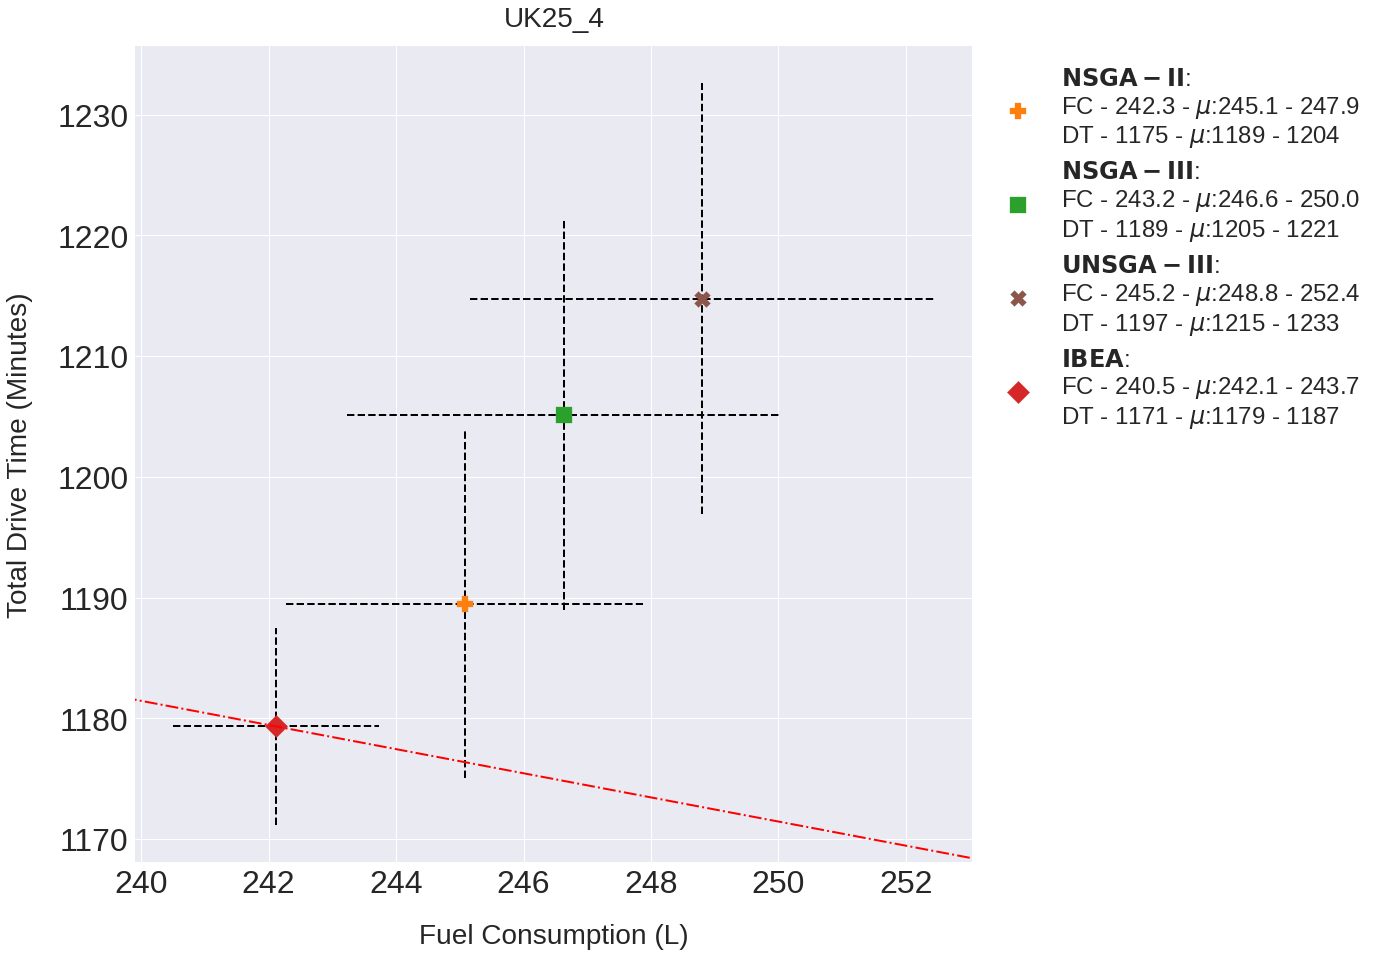

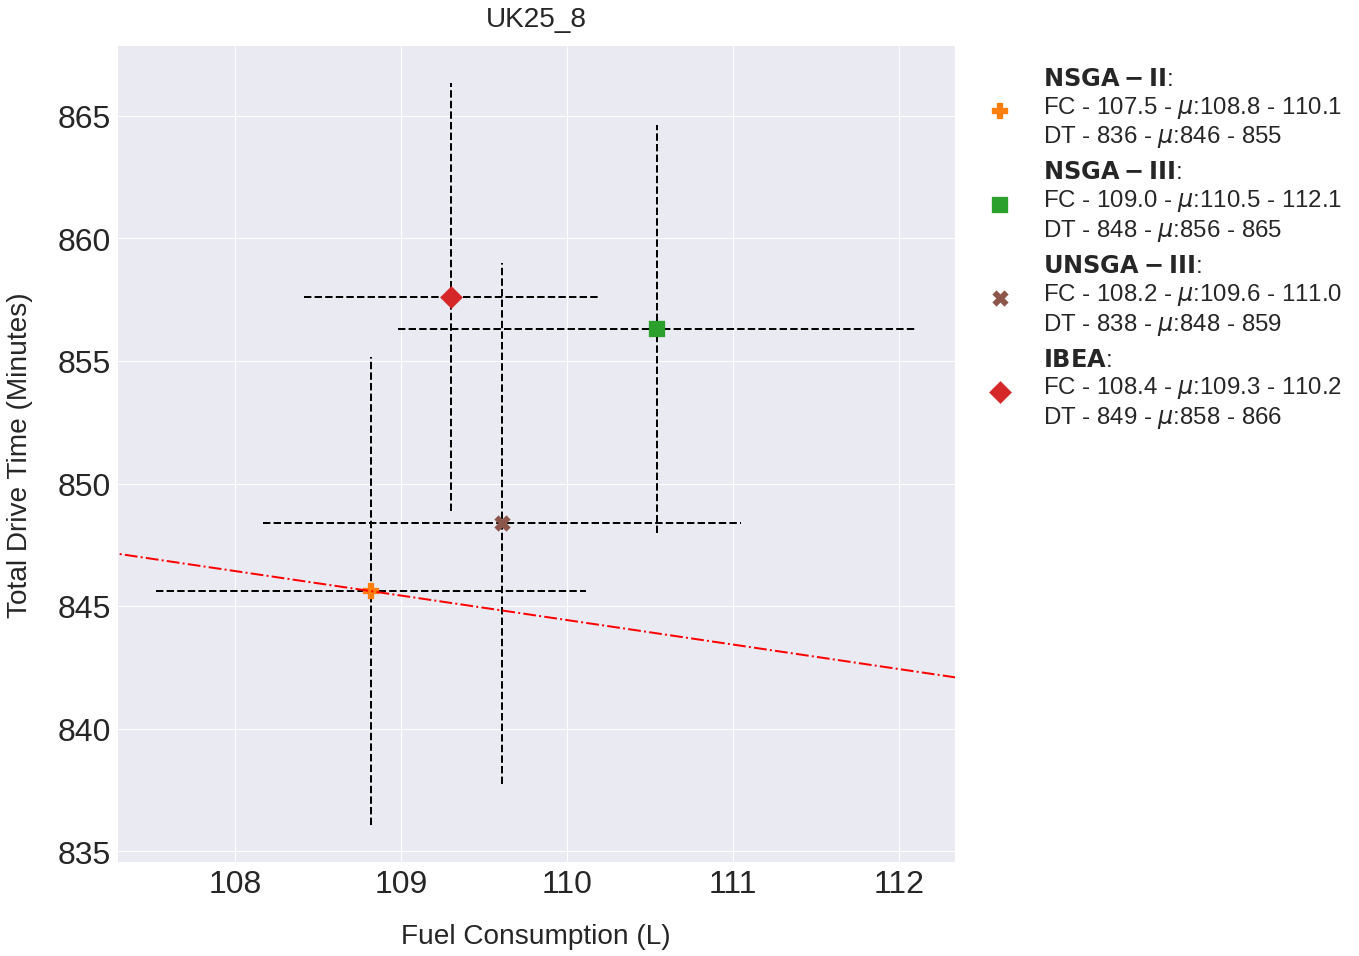

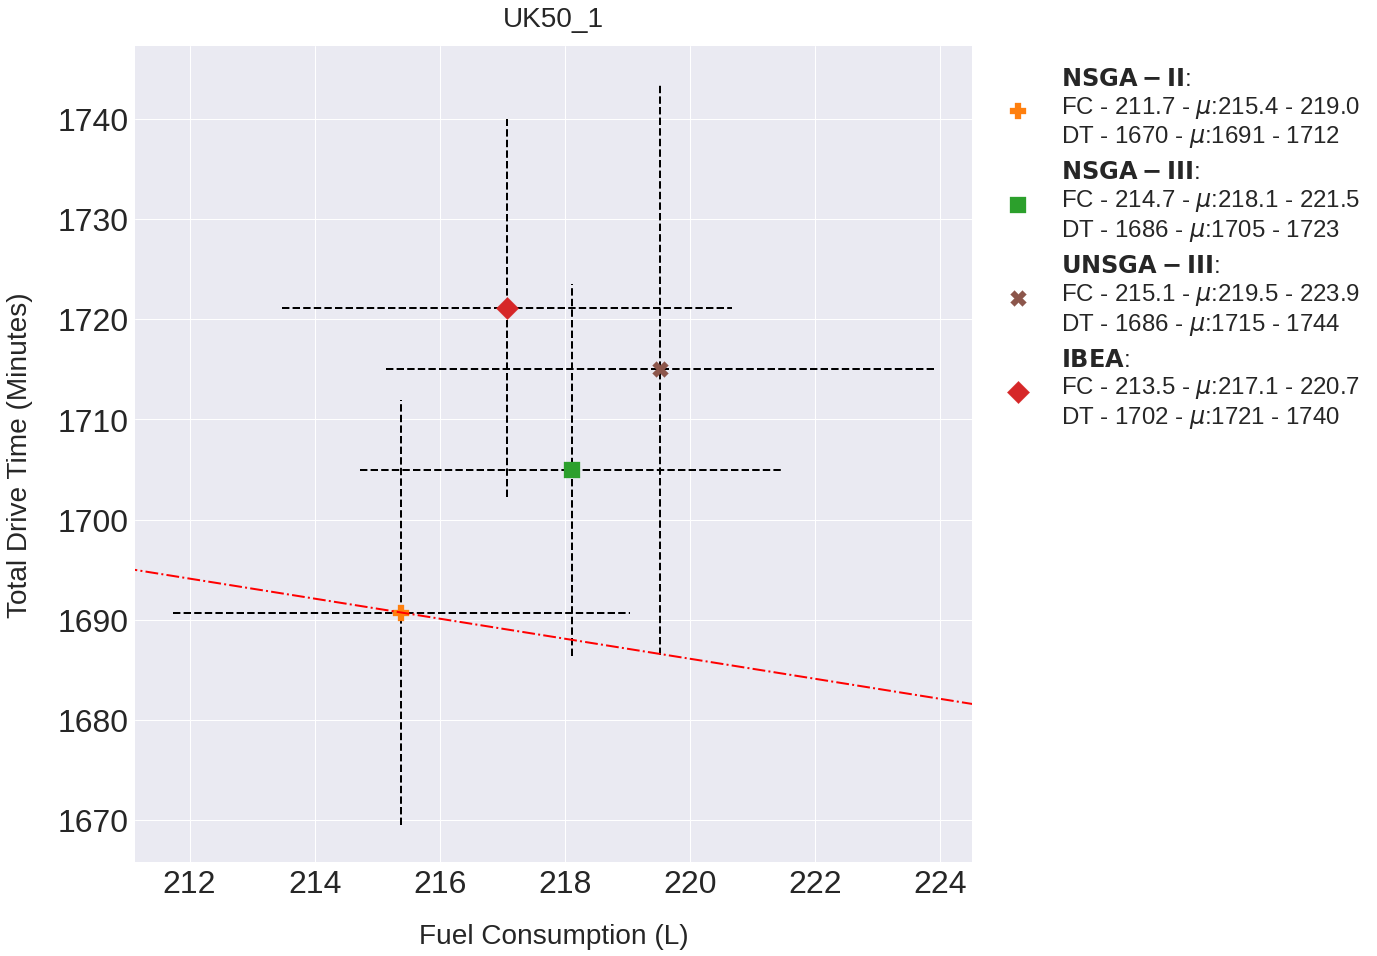

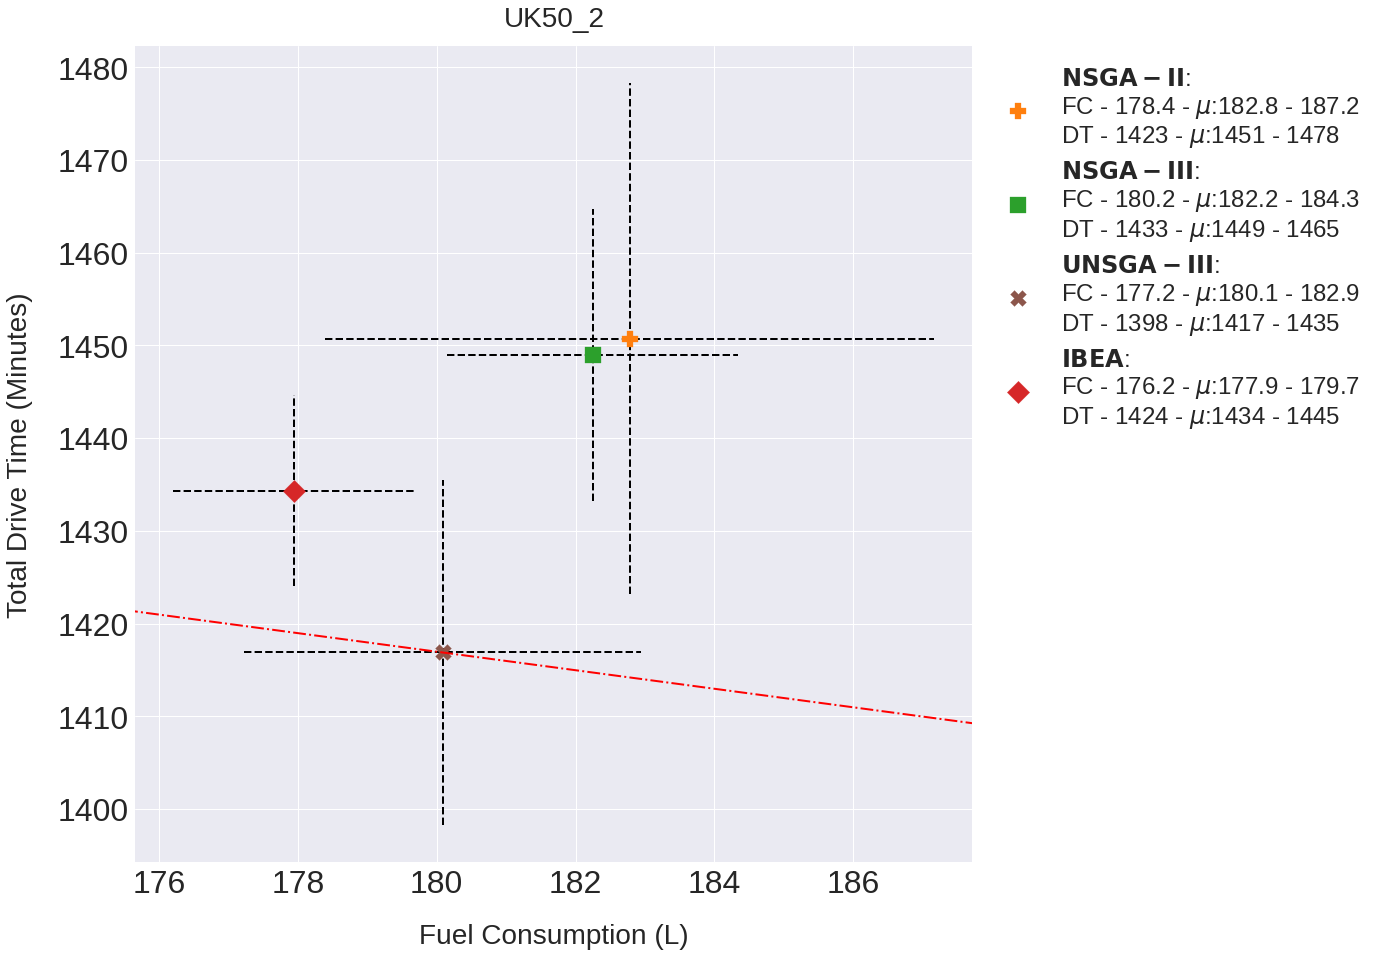

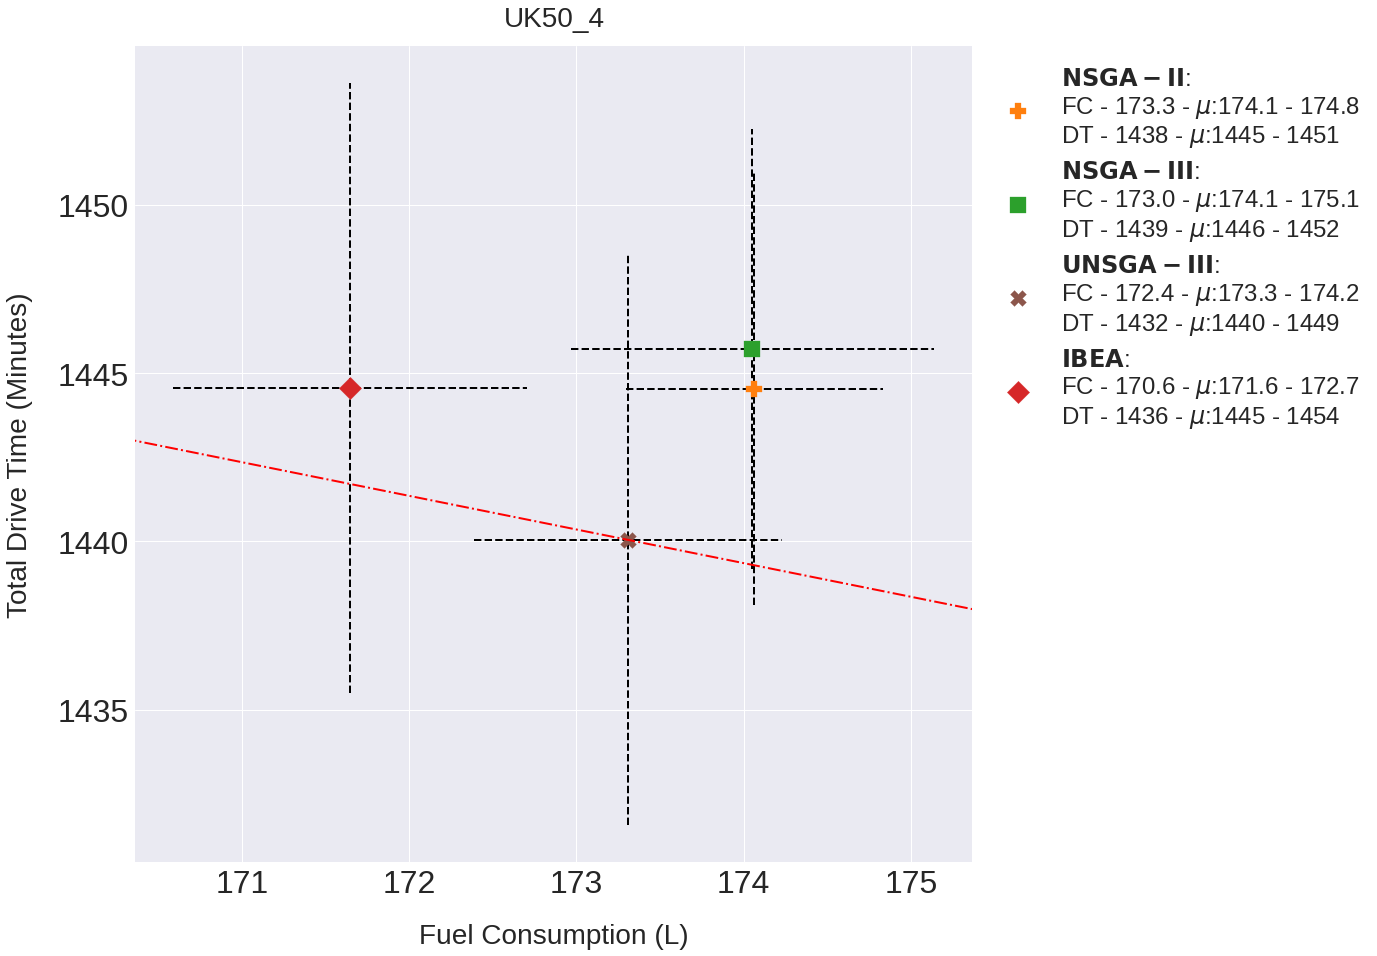

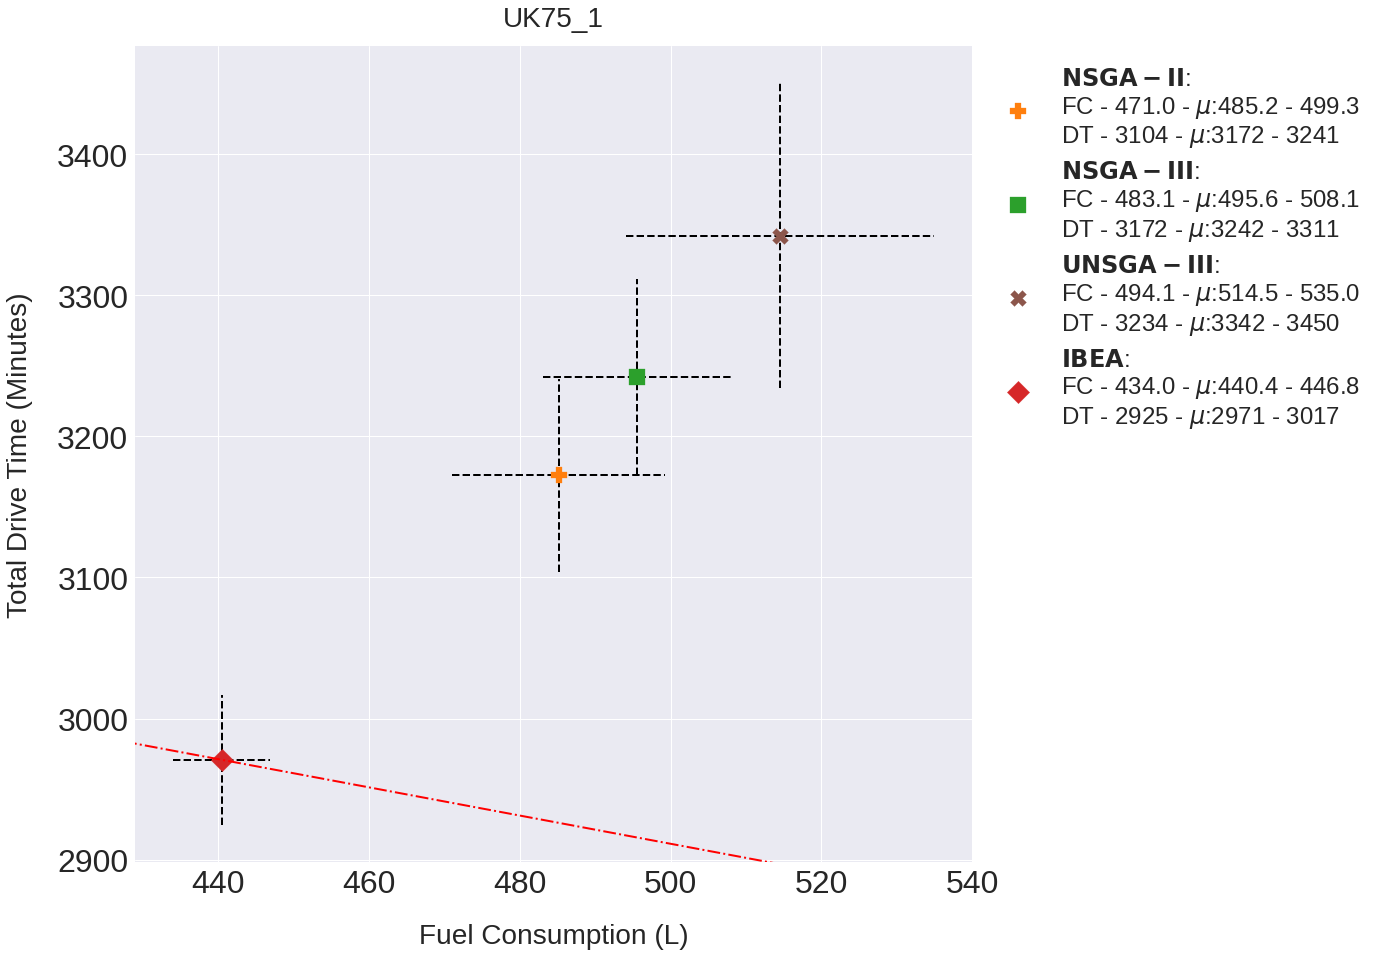

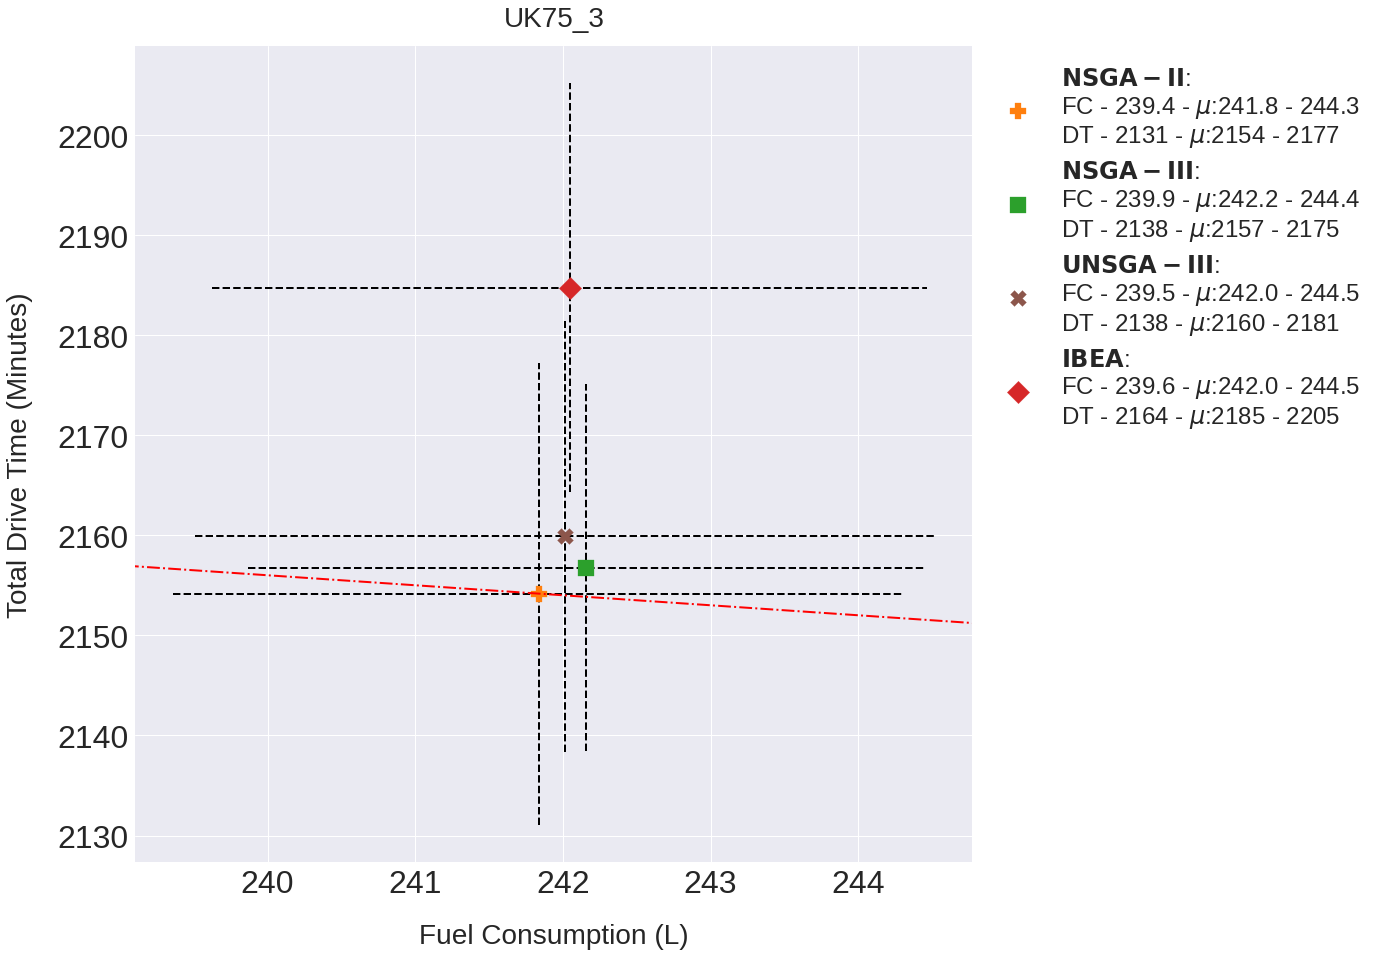

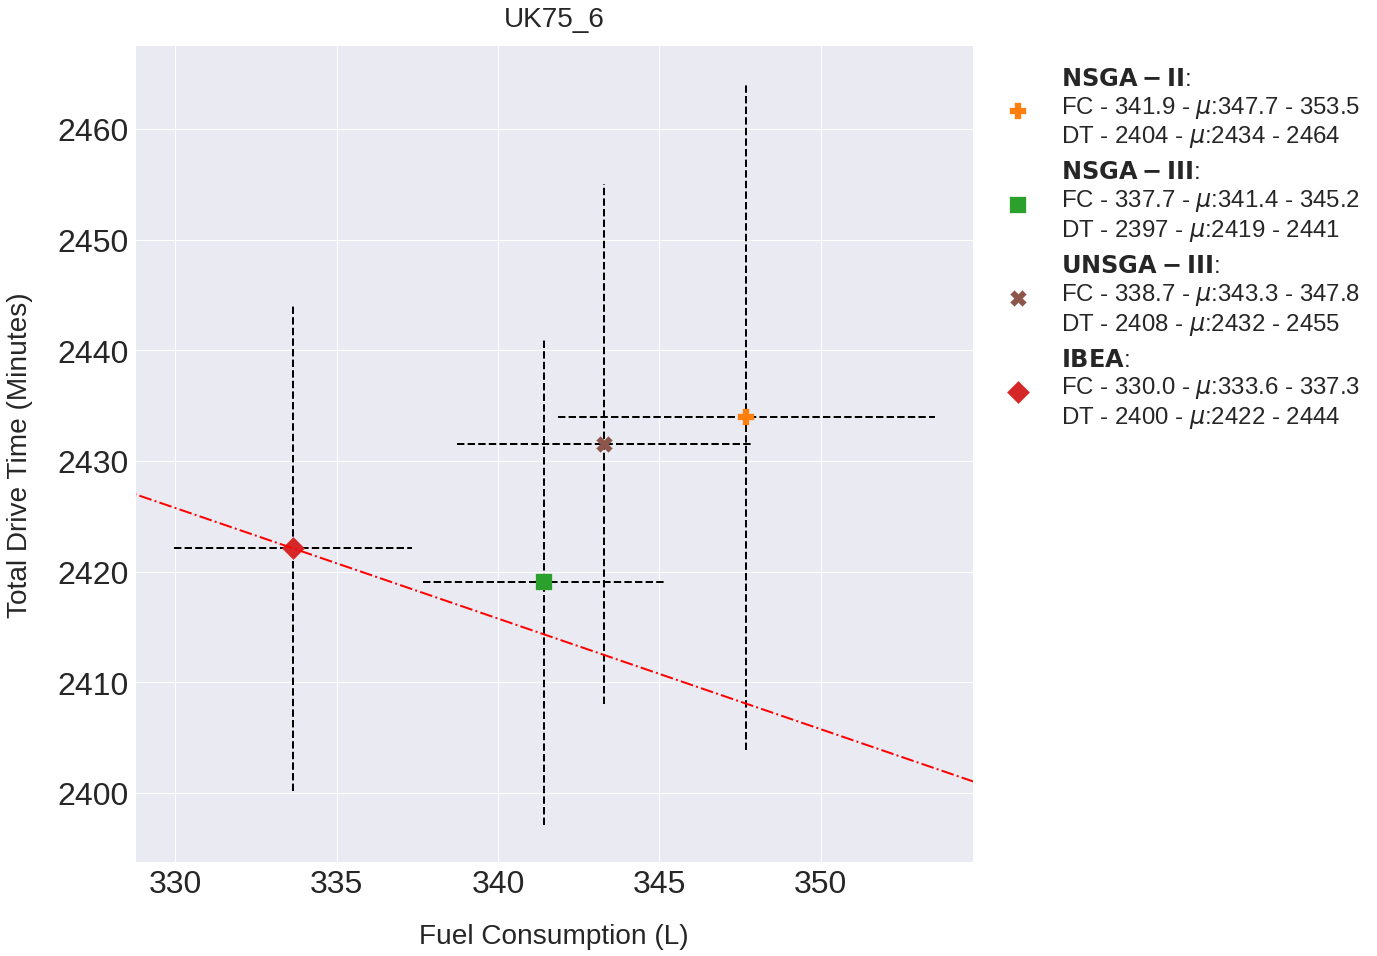

In [11]:
from scipy import interpolate
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    #print(NSGA2_data_dataset)
    algorithms = [NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels, show_mean_eval=False,minmax_scale=False)
    
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    point_1,point_2 = get_pareto_line(algorithms,plt.xlim(),plt.ylim()) 
     
    
    points = np.array([point_1,point_2])
  
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")

    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)
    
    
    
    
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(dataset)
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Total Drive Time (Minutes)",labelpad=24)
    plt.show()

# Load Bi-objective data

In [54]:
SA_bi_objective = combine_datasets("SA", "parameter_data/reruns/")
print("GA")
GA_bi_objective = combine_datasets("GA", "parameter_data/reruns/")
print("NSGA2")
NSGA2_bi_objective = combine_datasets("NSGA2", "parameter_data/reruns_L1/")
print("NSGA3")
NSGA3_bi_objective = combine_datasets("NSGA3", "parameter_data/reruns_L1/")
print("UNSGA3")
UNSGA3_bi_objective = combine_datasets("UNSGA3", "parameter_data/reruns_L1/")
print("IBEA")
IBEA_bi_objective = combine_datasets("IBEA", "parameter_data/reruns_L1/")

GA
NSGA2
NSGA3
UNSGA3
IBEA


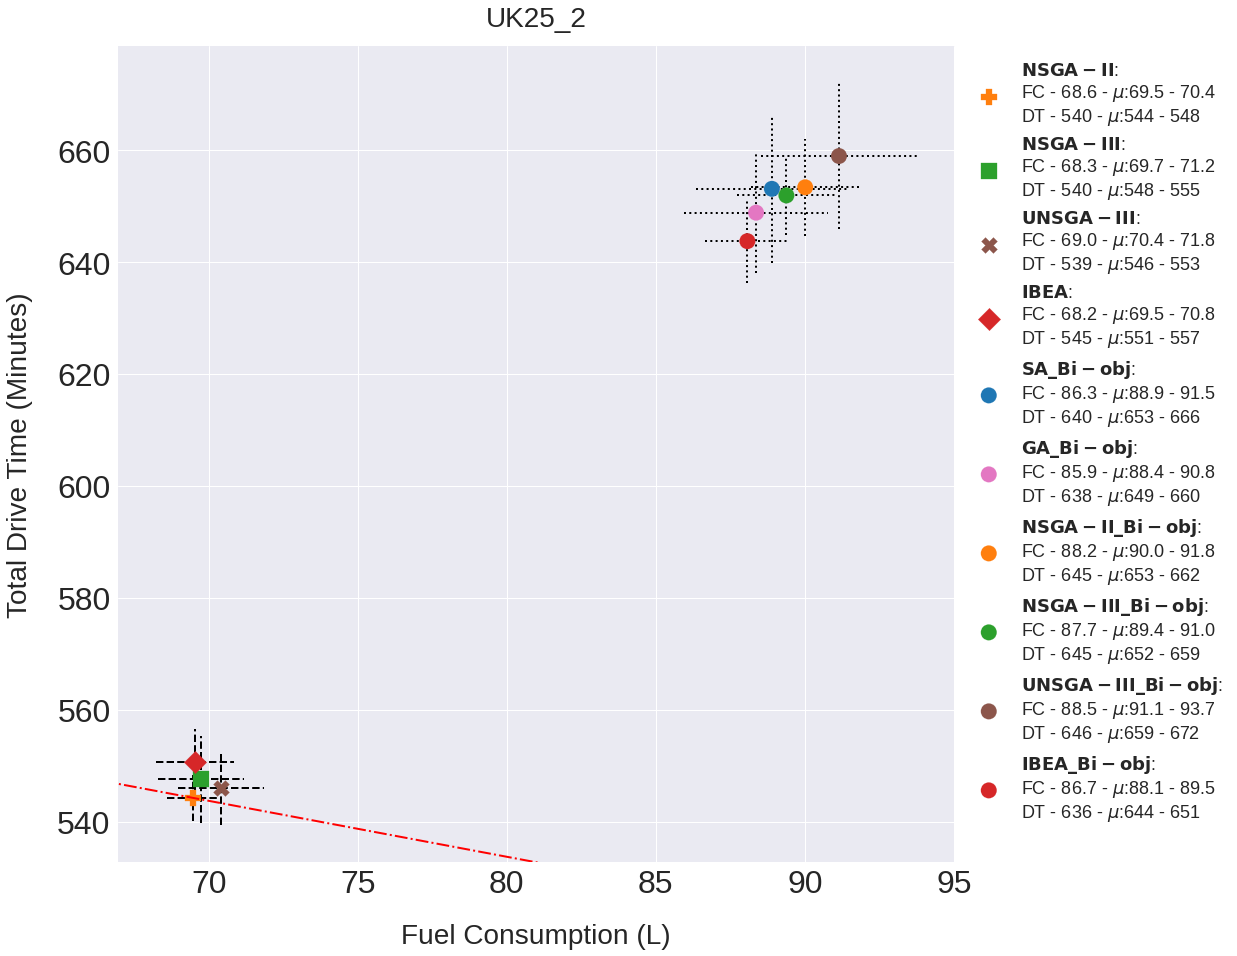

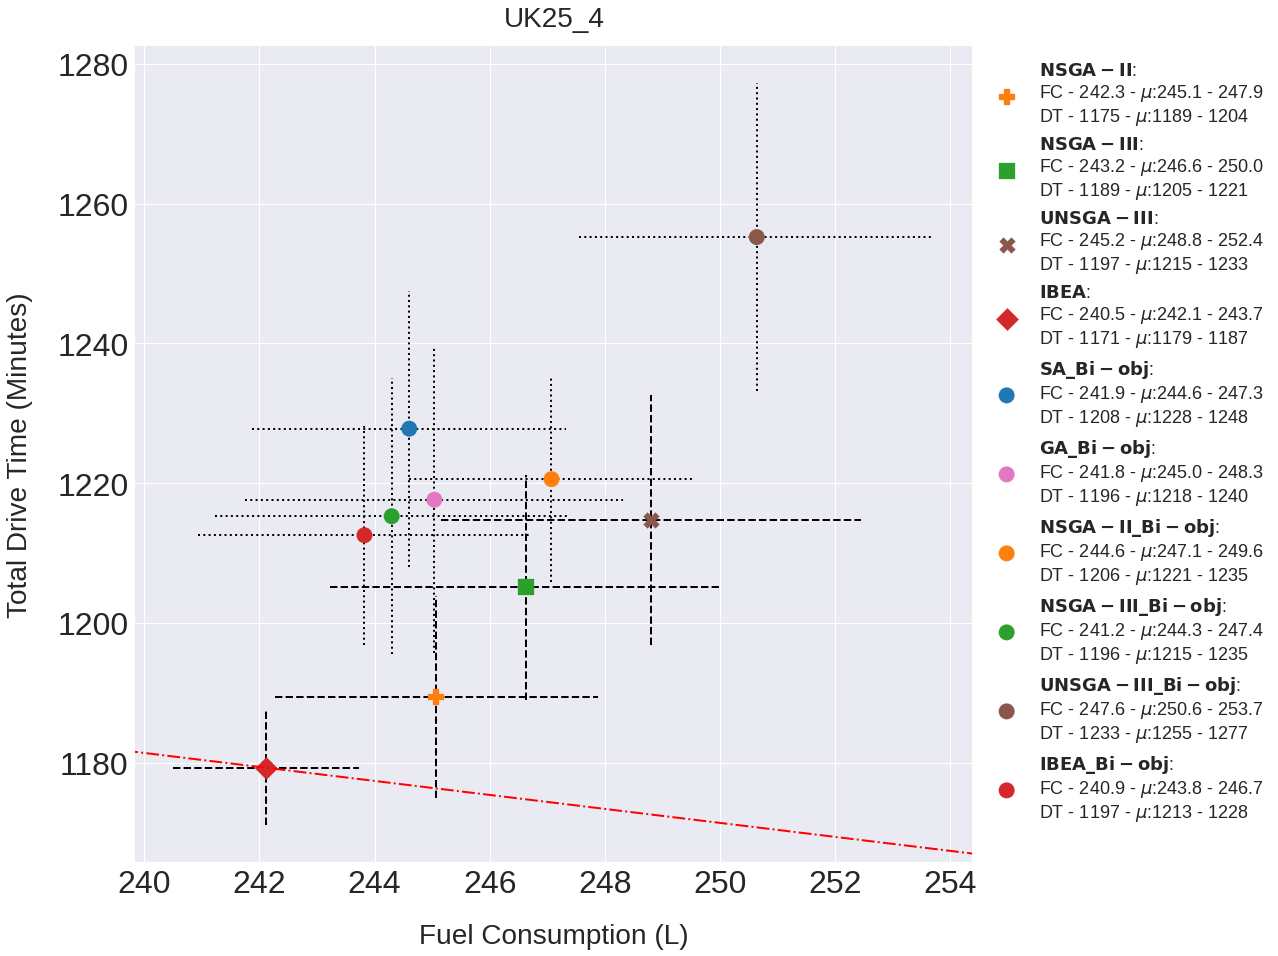

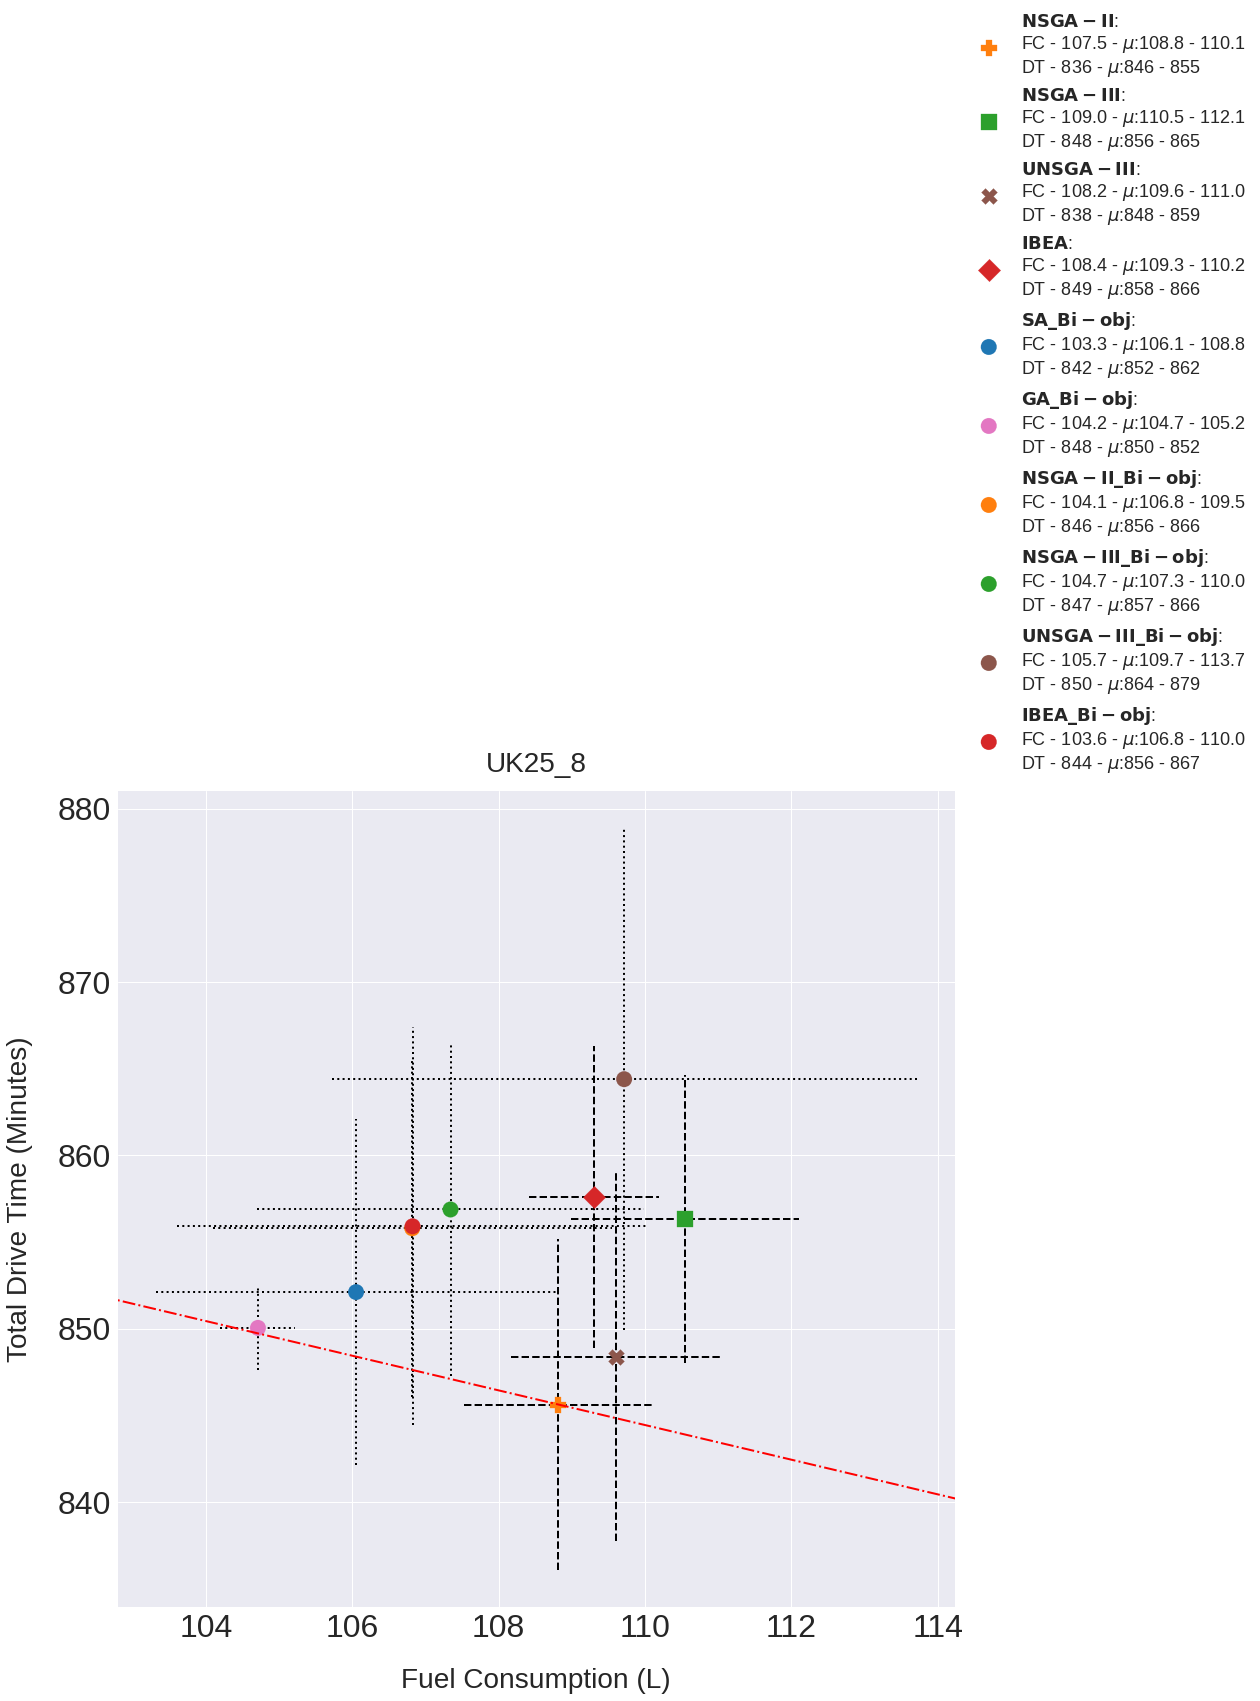

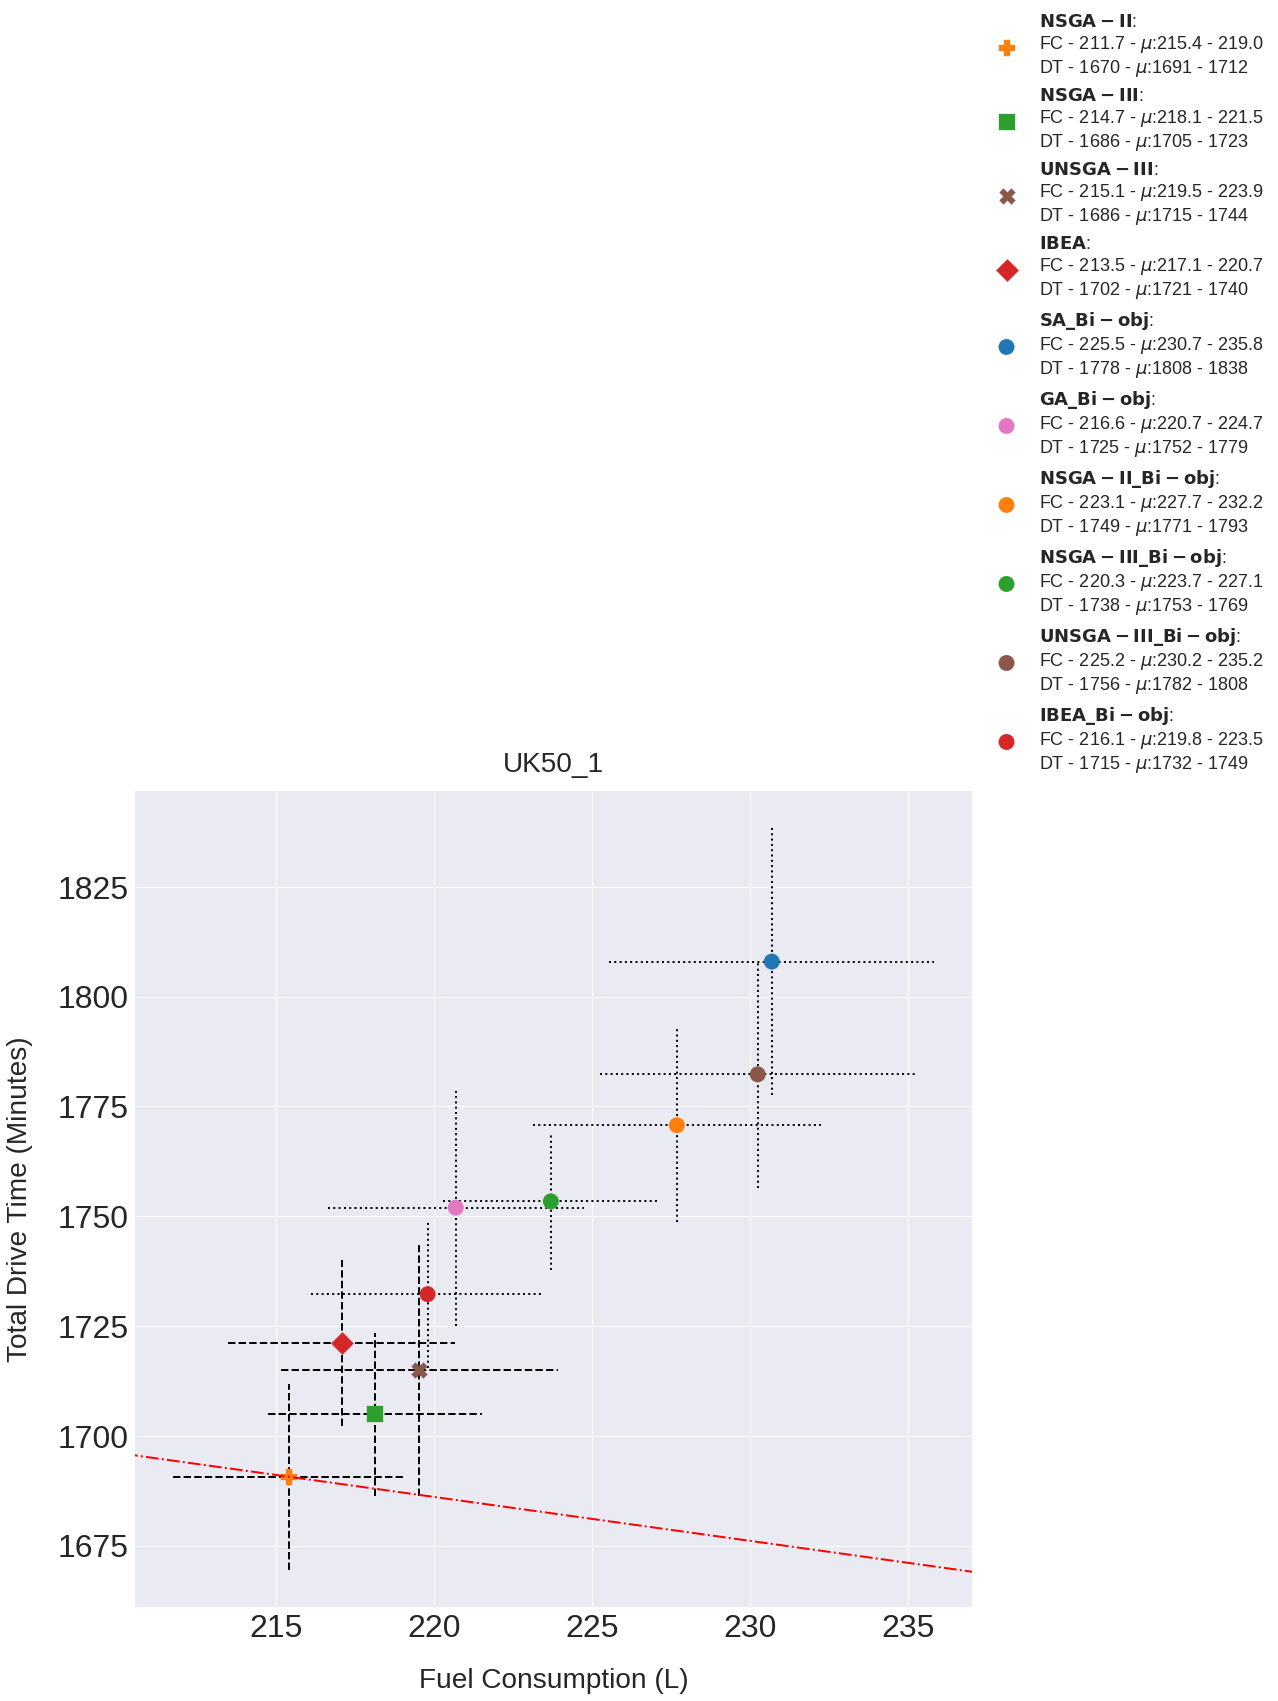

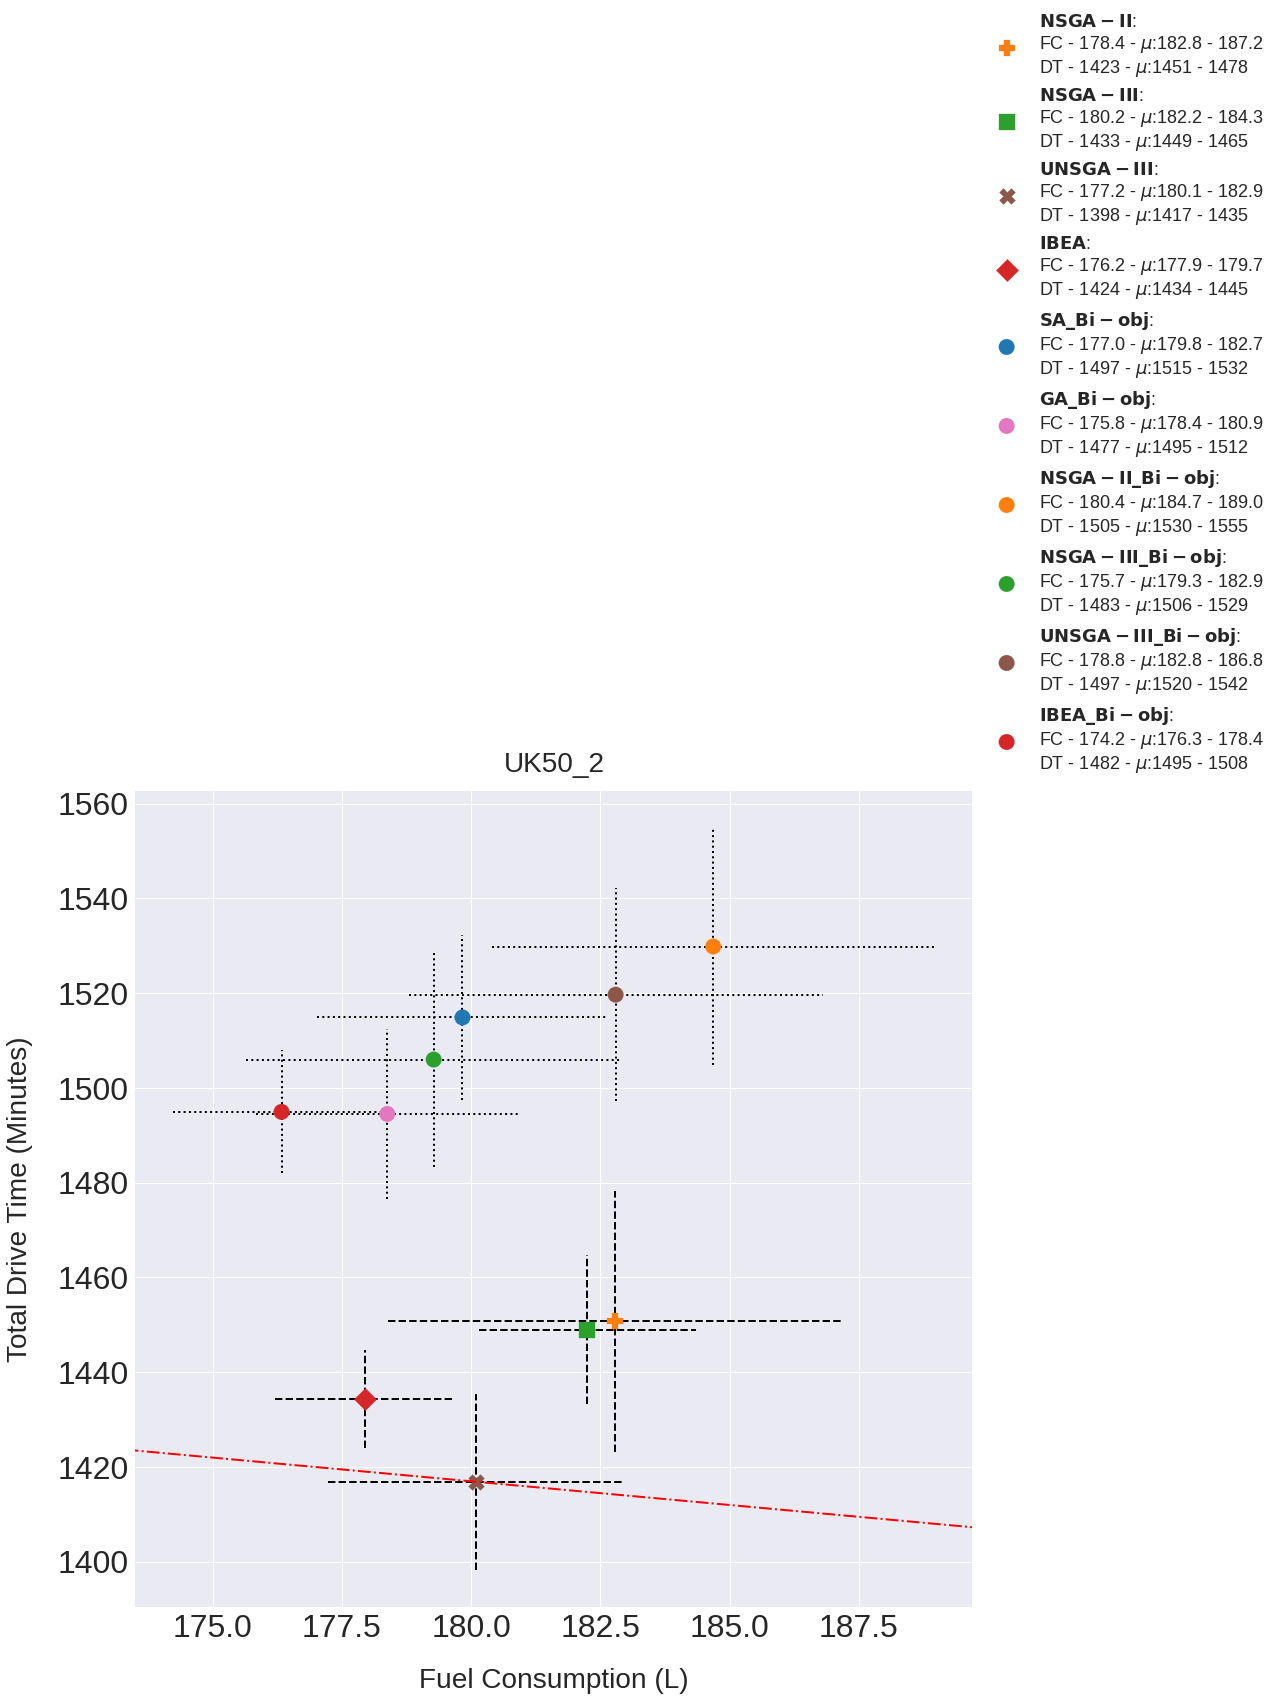

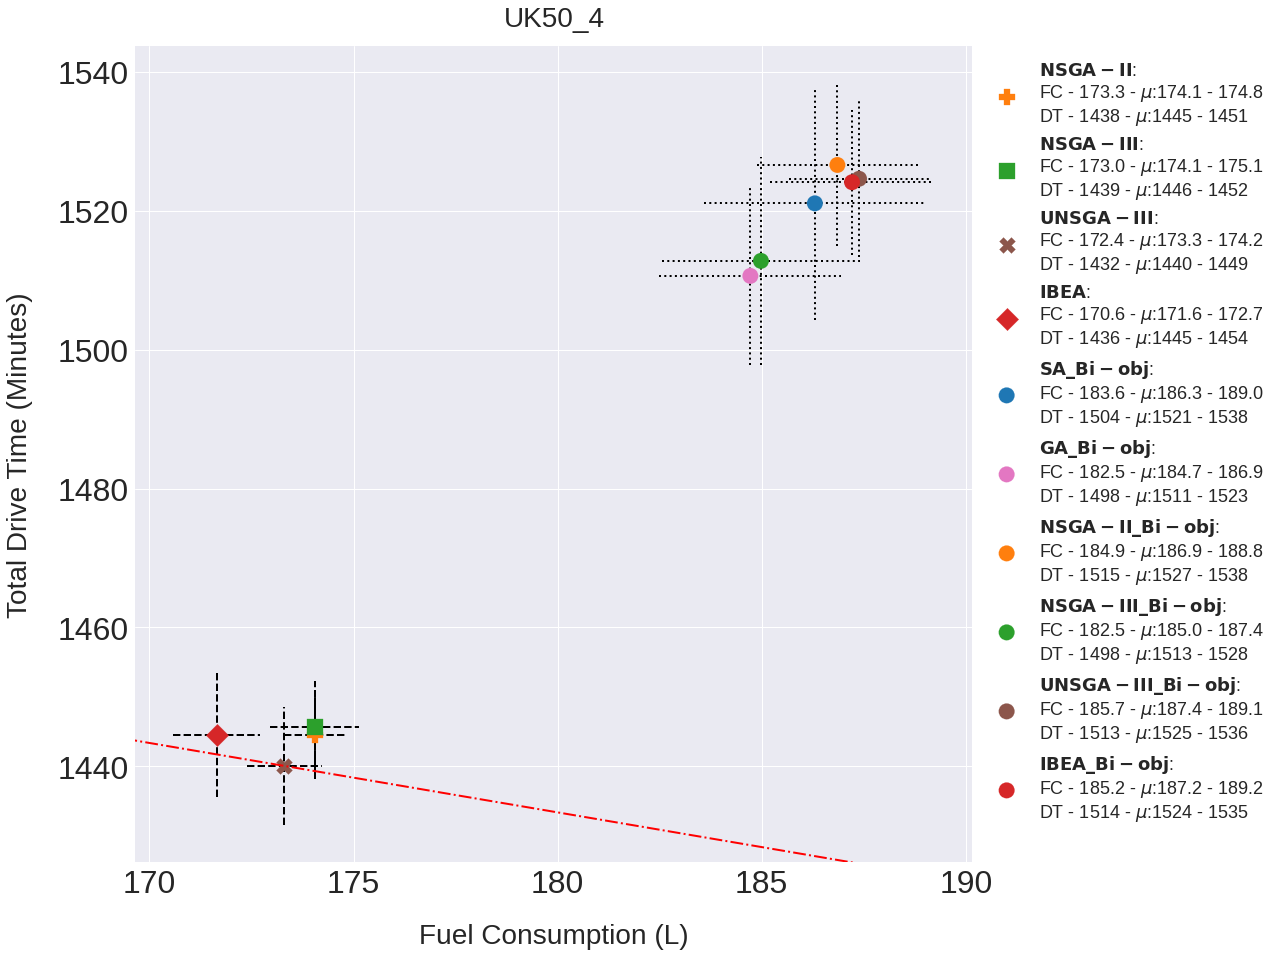

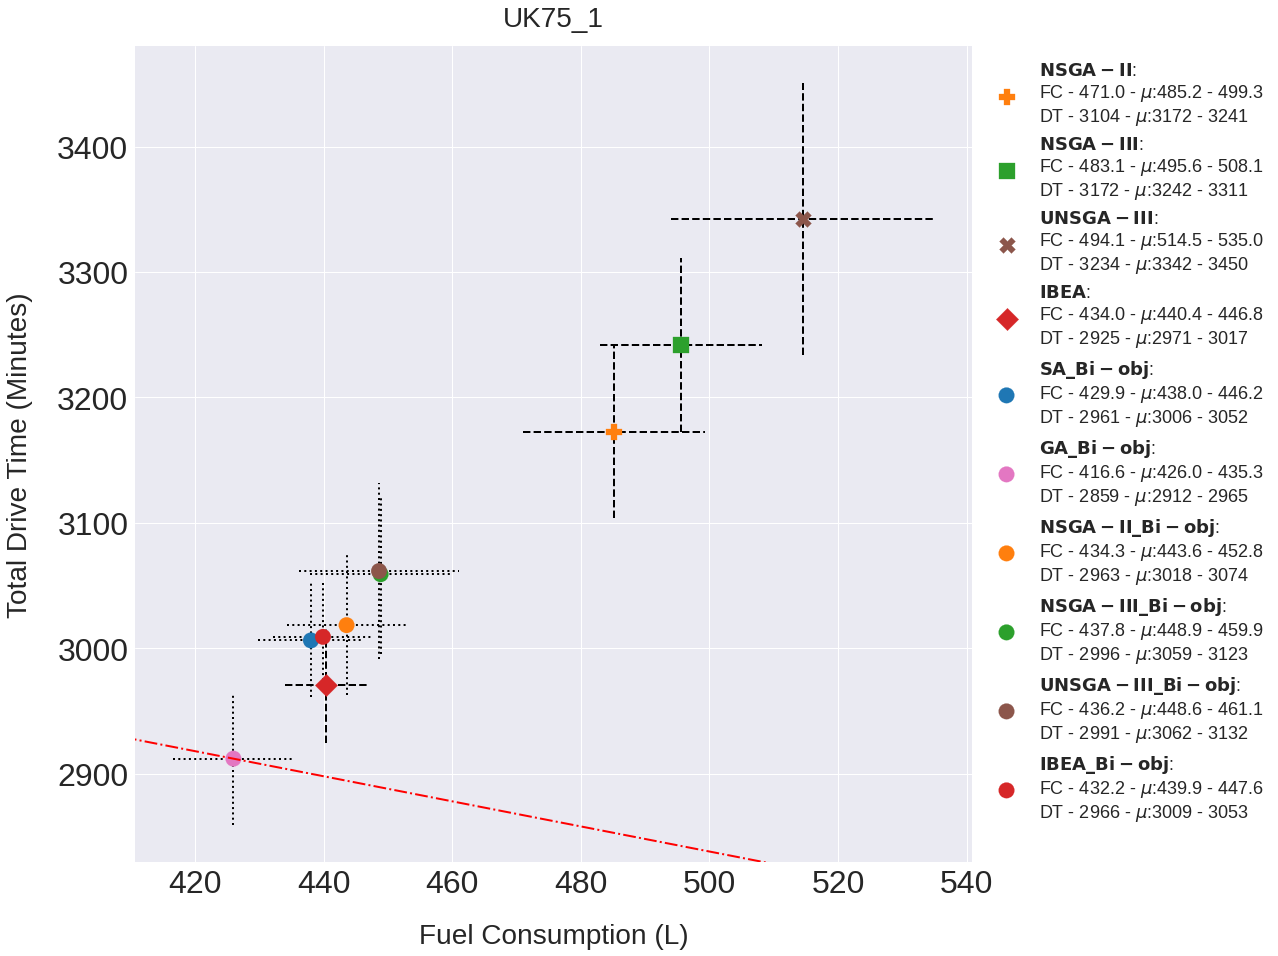

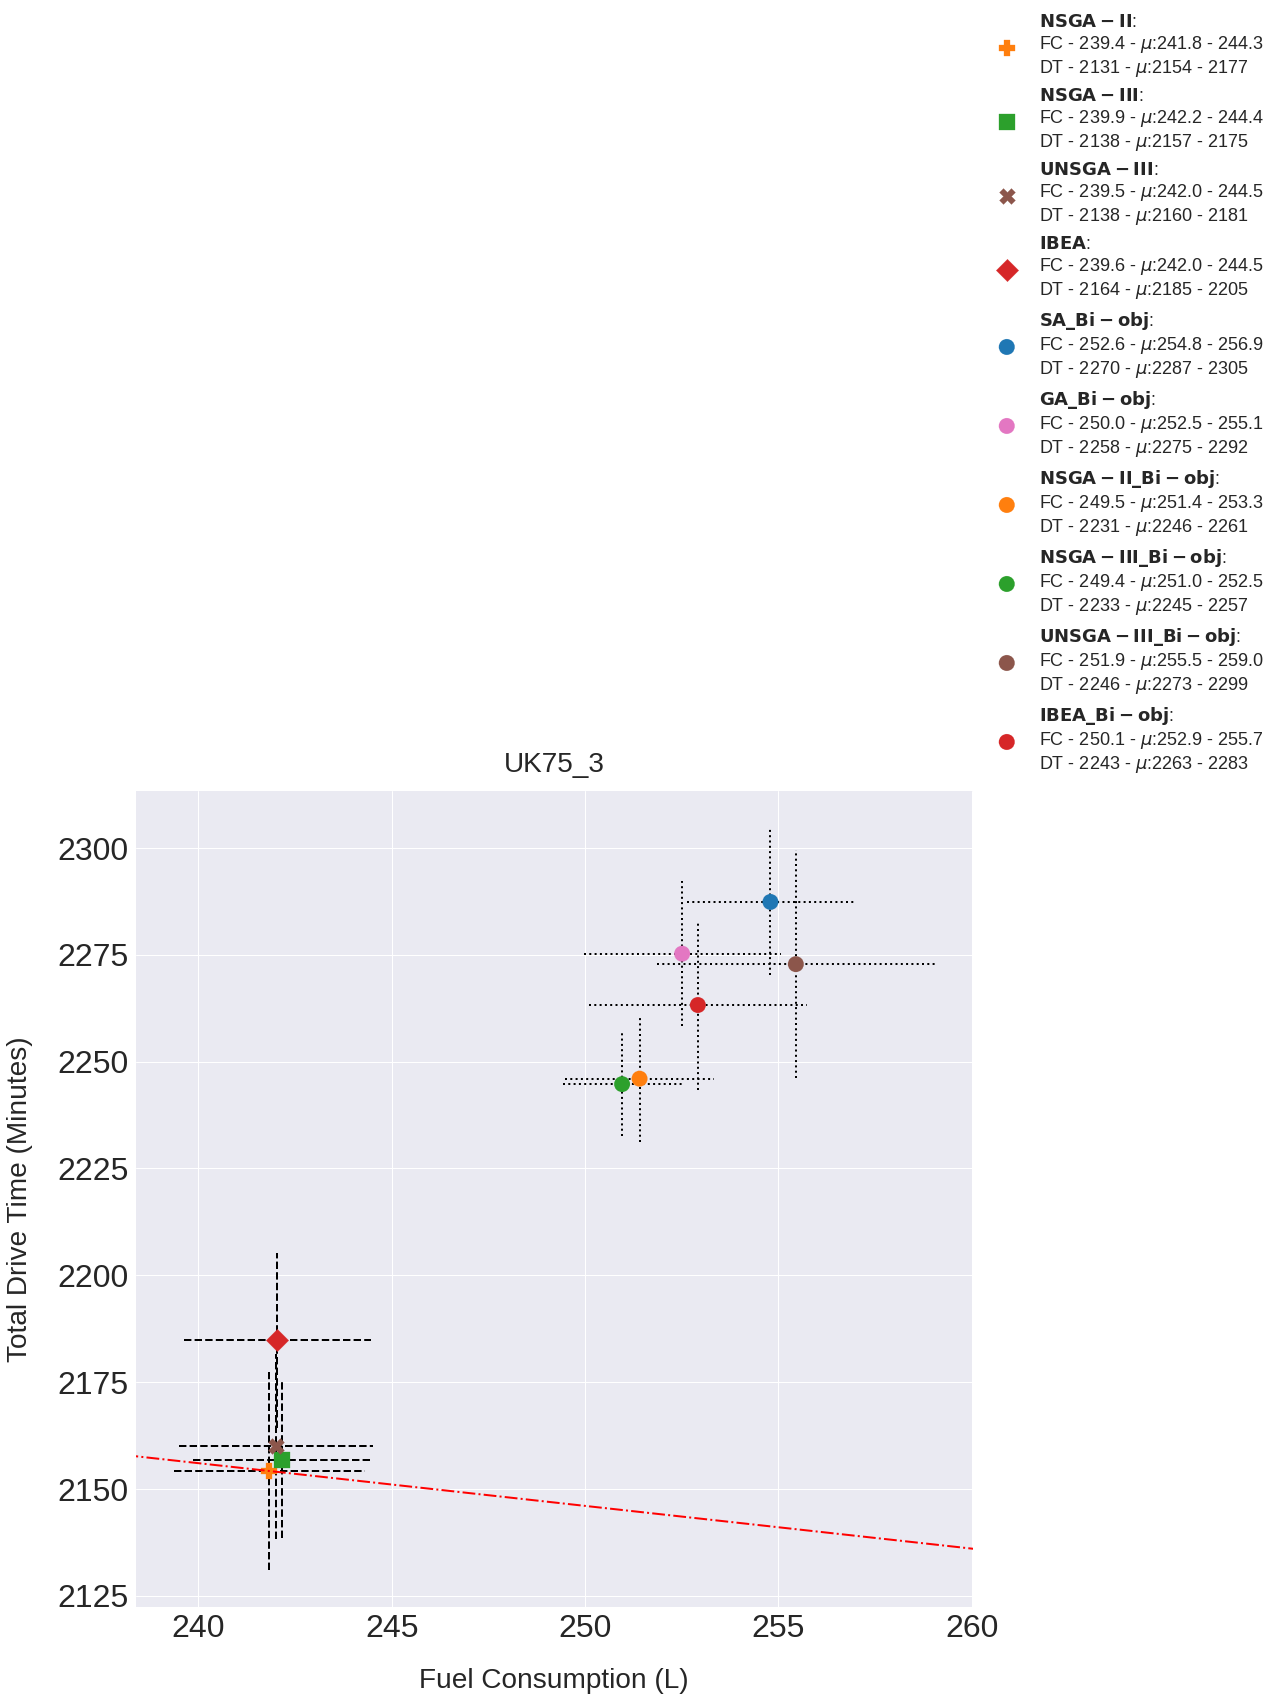

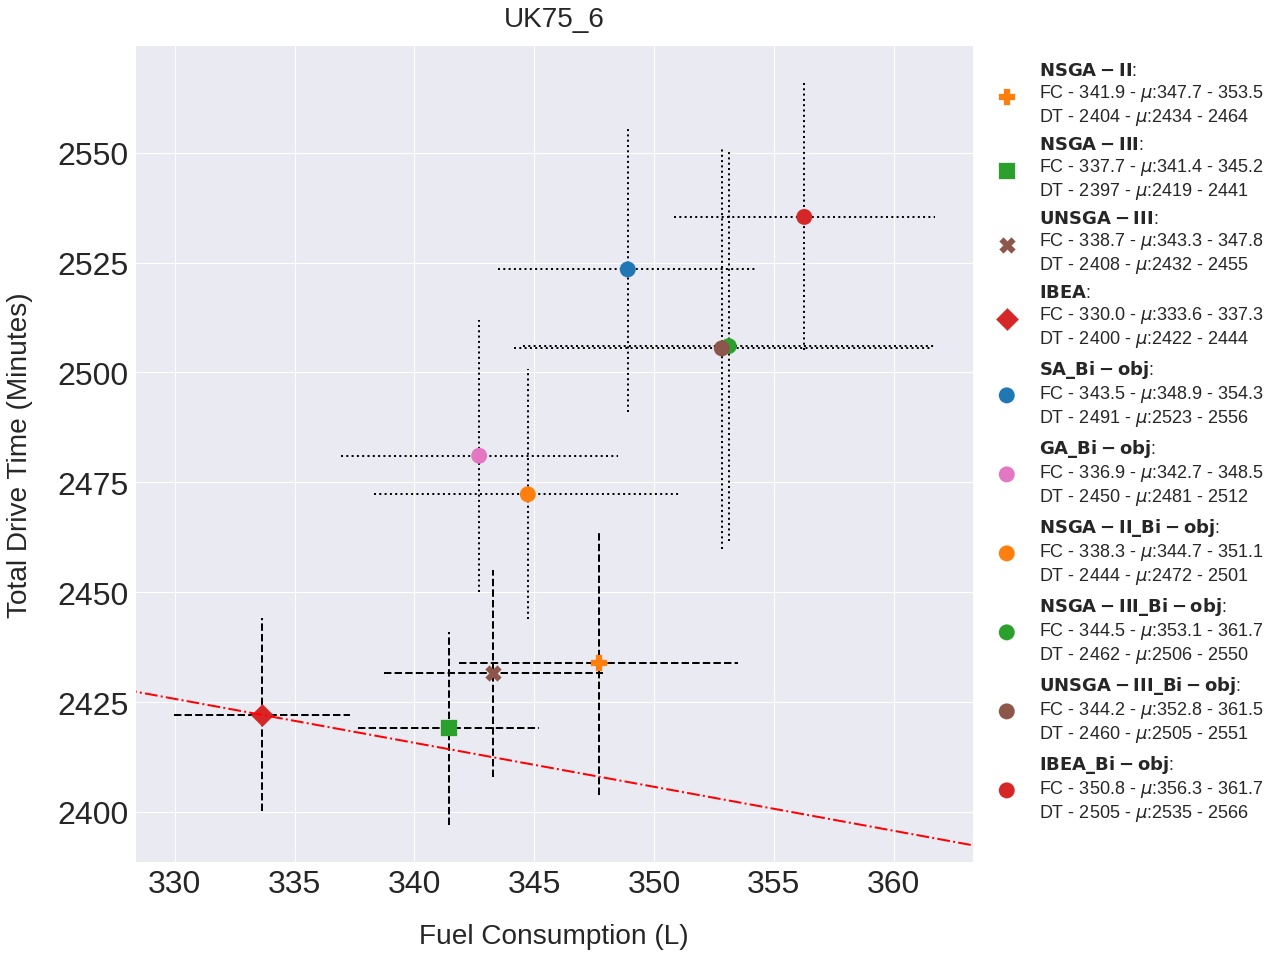

In [45]:
from scipy import interpolate
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    
    SA_bi_obj = SA_bi_objective.where(SA_bi_objective.dataset == dataset).dropna(how="all").mean()
    GA_bi_obj = GA_bi_objective.where(GA_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA2_bi_obj = NSGA2_bi_objective.where(NSGA2_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA3_bi_obj = NSGA3_bi_objective.where(NSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    UNSGA3_bi_obj = UNSGA3_bi_objective.where(UNSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    IBEA_bi_obj = IBEA_bi_objective.where(IBEA_bi_objective.dataset == dataset).dropna(how="all").mean()
    
    algorithms = [NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset,
                  SA_bi_obj,GA_bi_obj,NSGA2_bi_obj,NSGA3_bi_obj,UNSGA3_bi_obj,IBEA_bi_obj]
    
    labels = ["NSGA-II", "NSGA-III", "UNSGA-III", "IBEA","SA\_Bi-obj","GA\_Bi-obj","NSGA-II\_Bi-obj","NSGA-III\_Bi-obj","UNSGA-III\_Bi-obj","IBEA\_Bi-obj"]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels, show_mean_eval=False,minmax_scale=False)
    
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    point_1,point_2 = get_pareto_line(algorithms,plt.xlim(),plt.ylim()) 
     
    
    points = np.array([point_1,point_2])
  
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")

    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)
    
    
    
    
    
    
    plt.legend(bbox_to_anchor=(1, 1),fontsize=18)
    plt.title(dataset)
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Total Drive Time (Minutes)",labelpad=24)
    plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_multi_obj{}.png".format(dataset),bbox_inches='tight')
    plt.show()

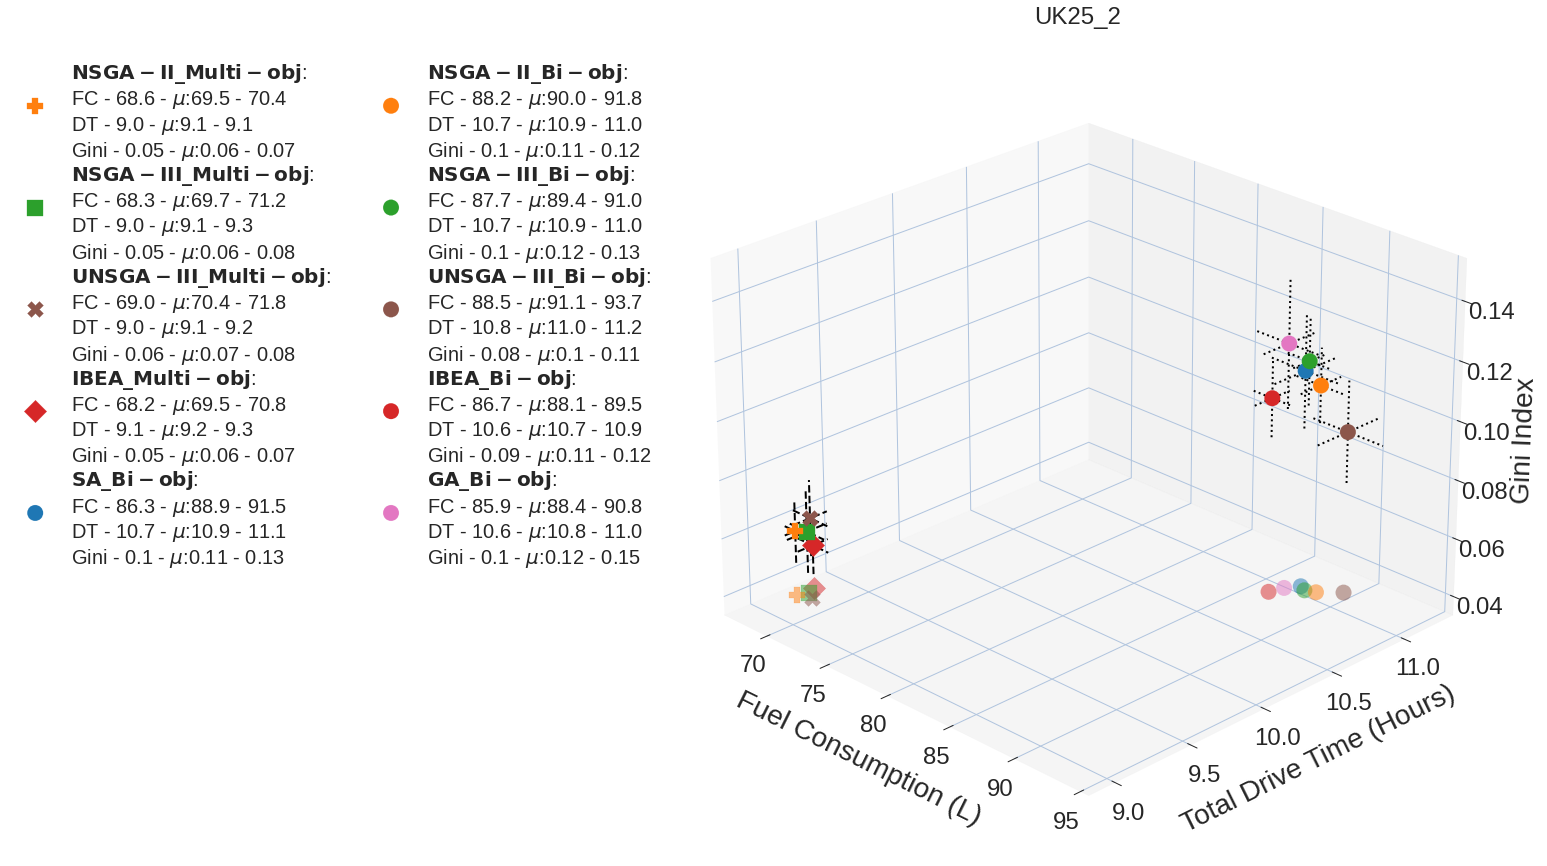

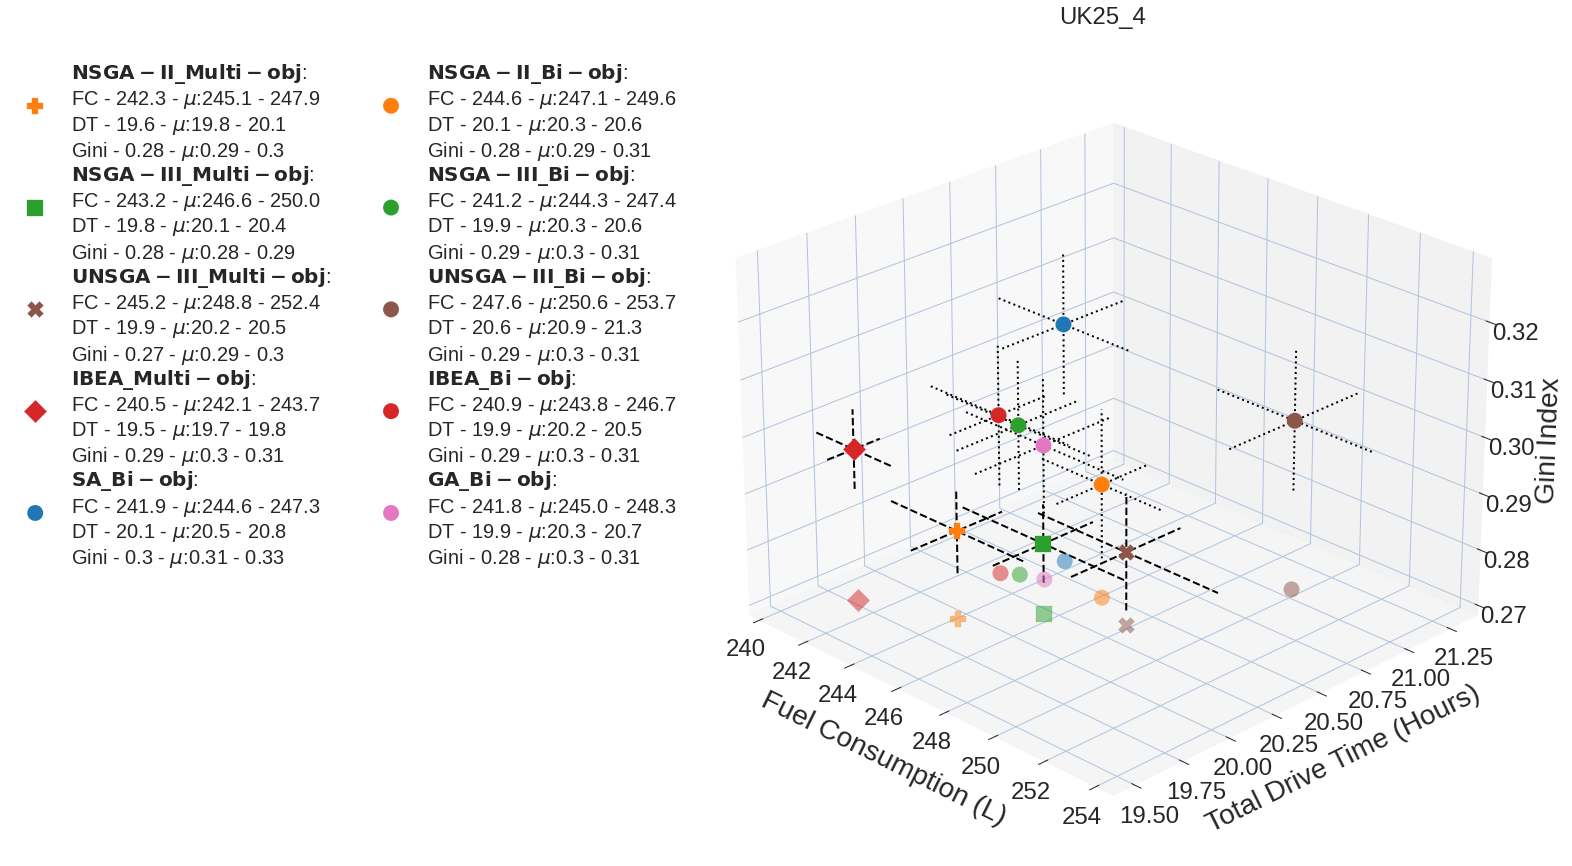

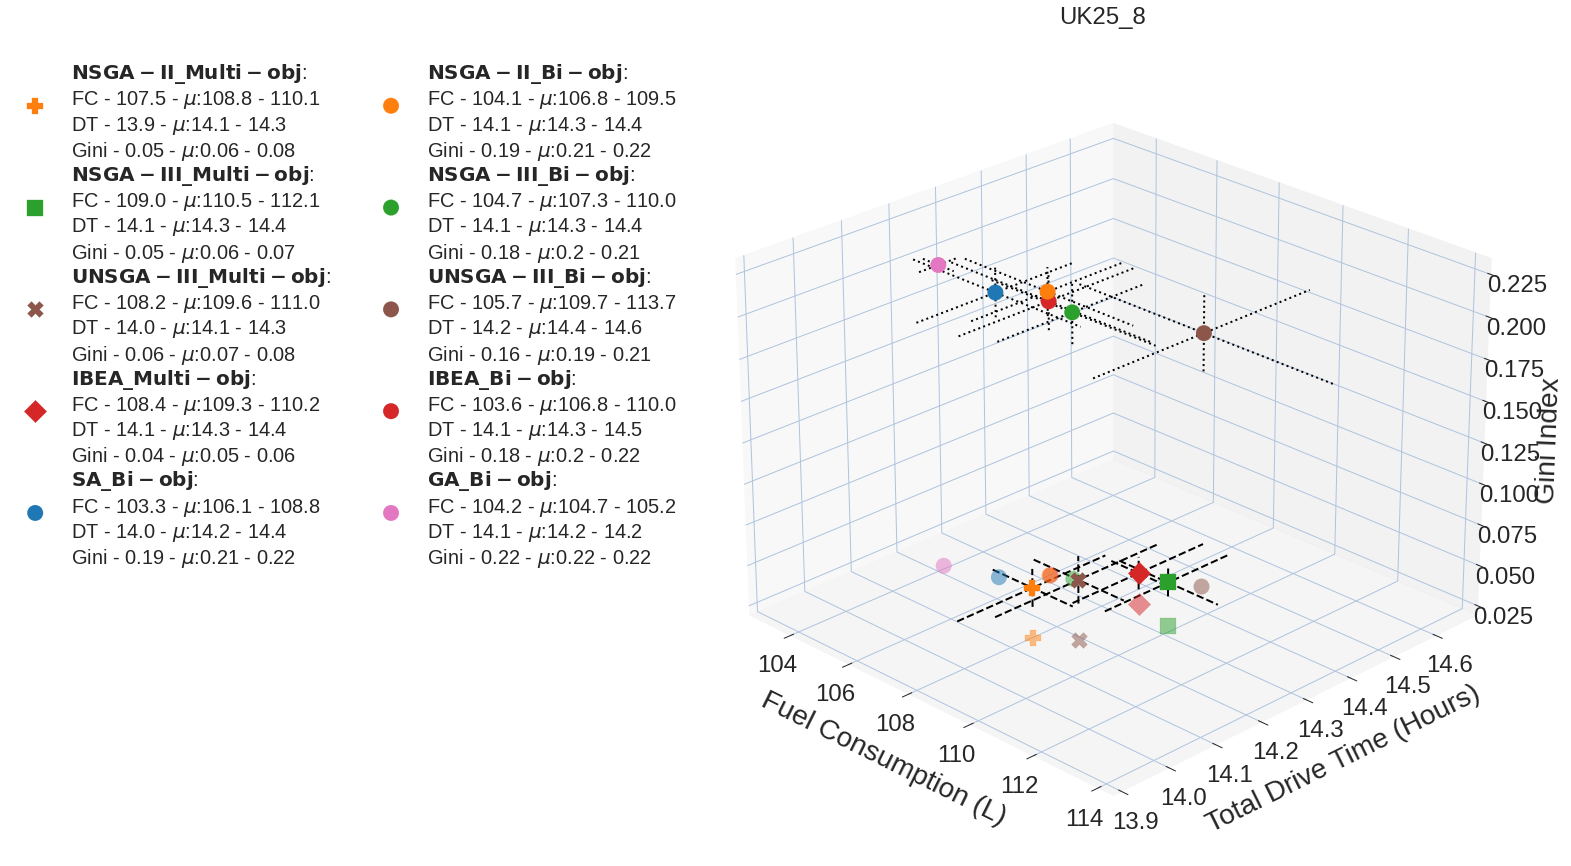

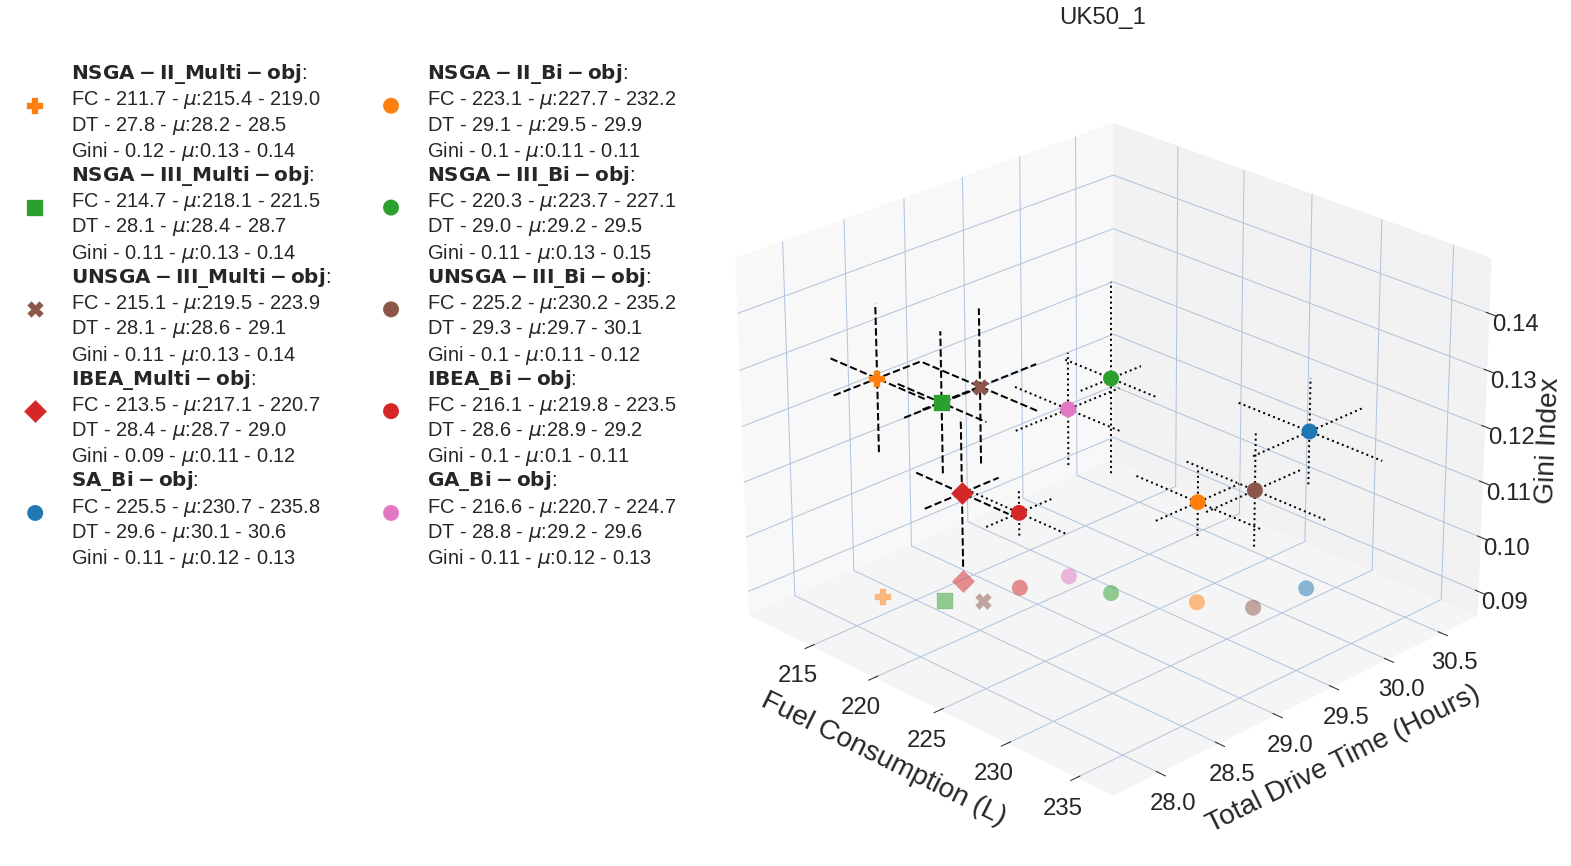

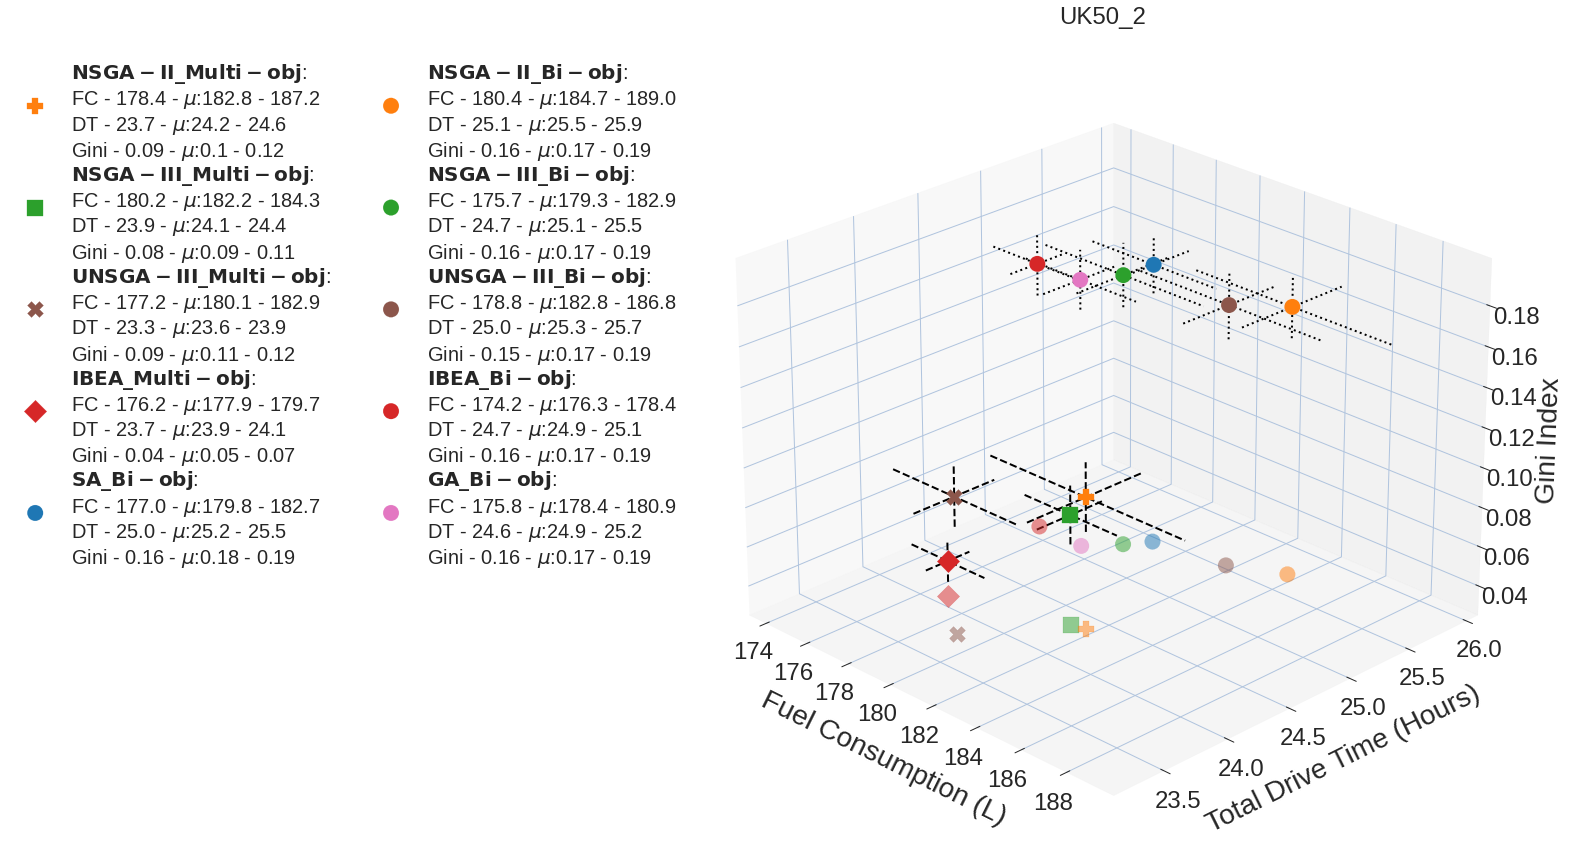

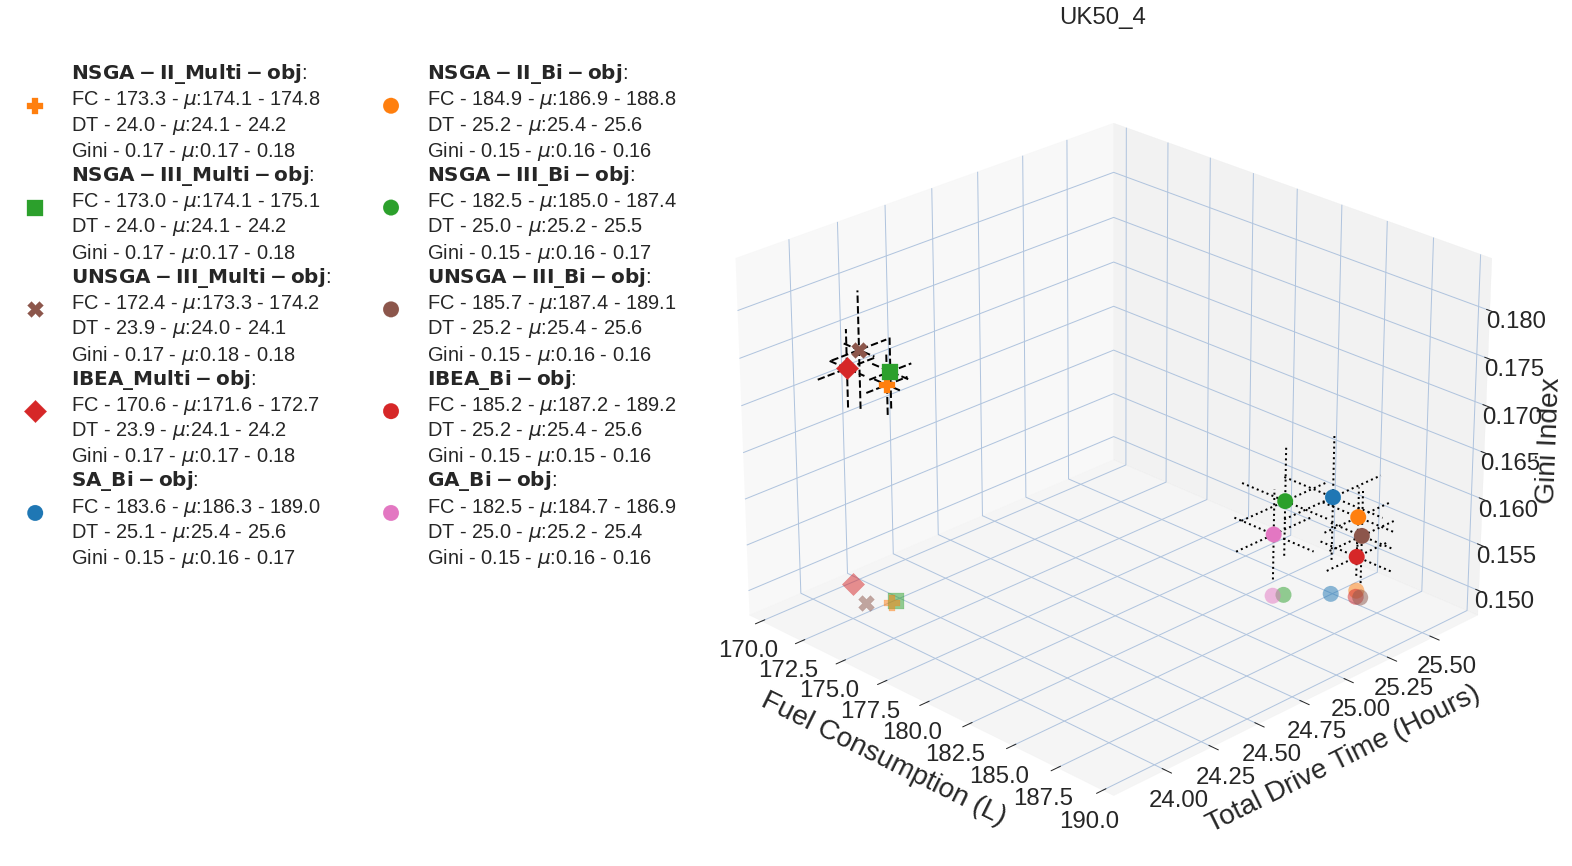

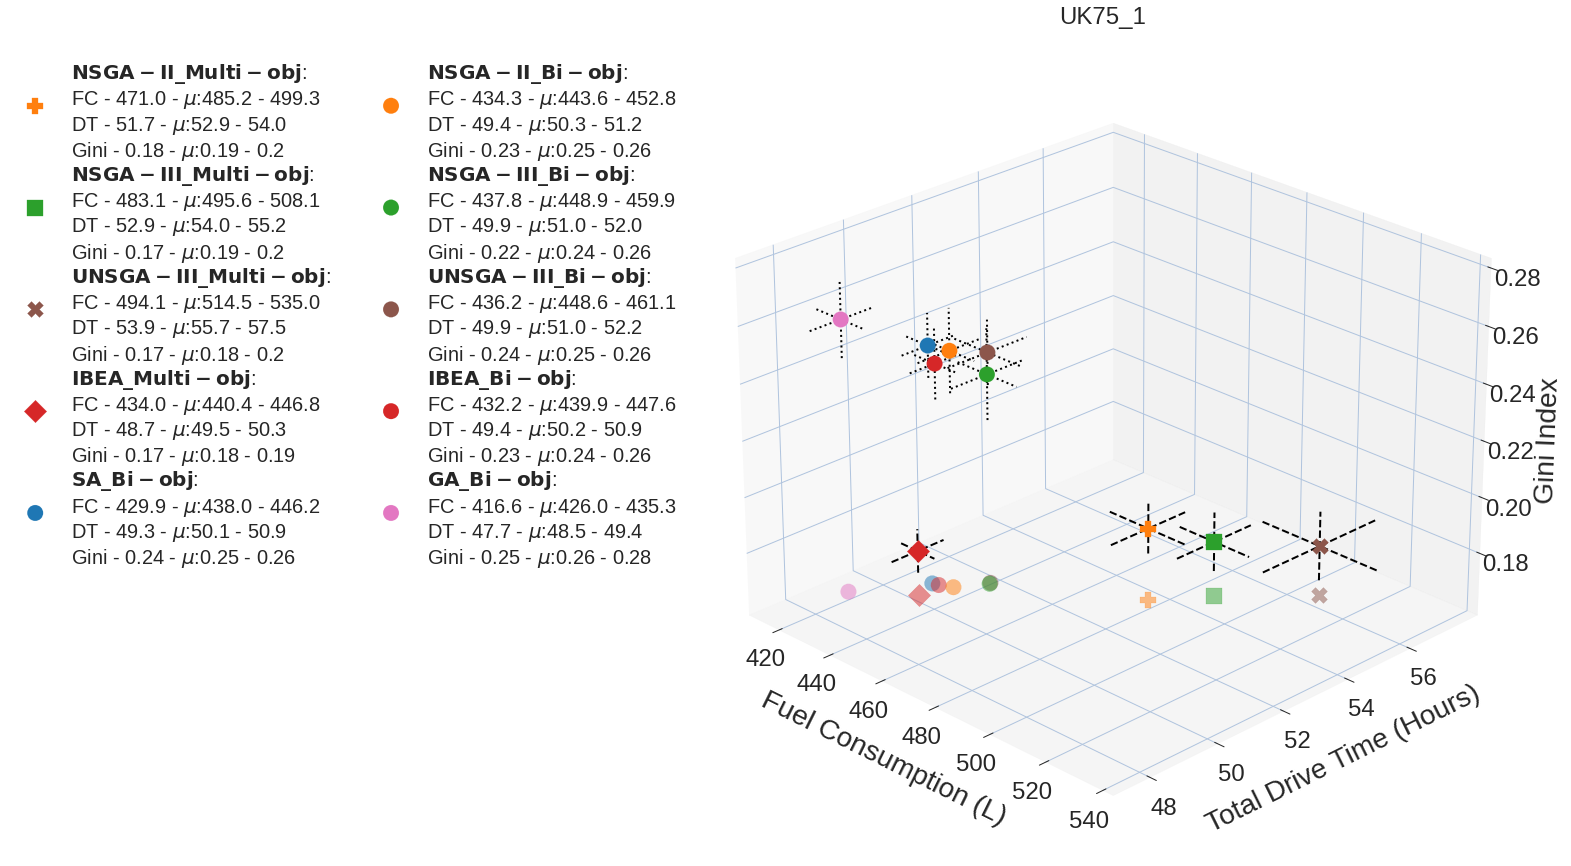

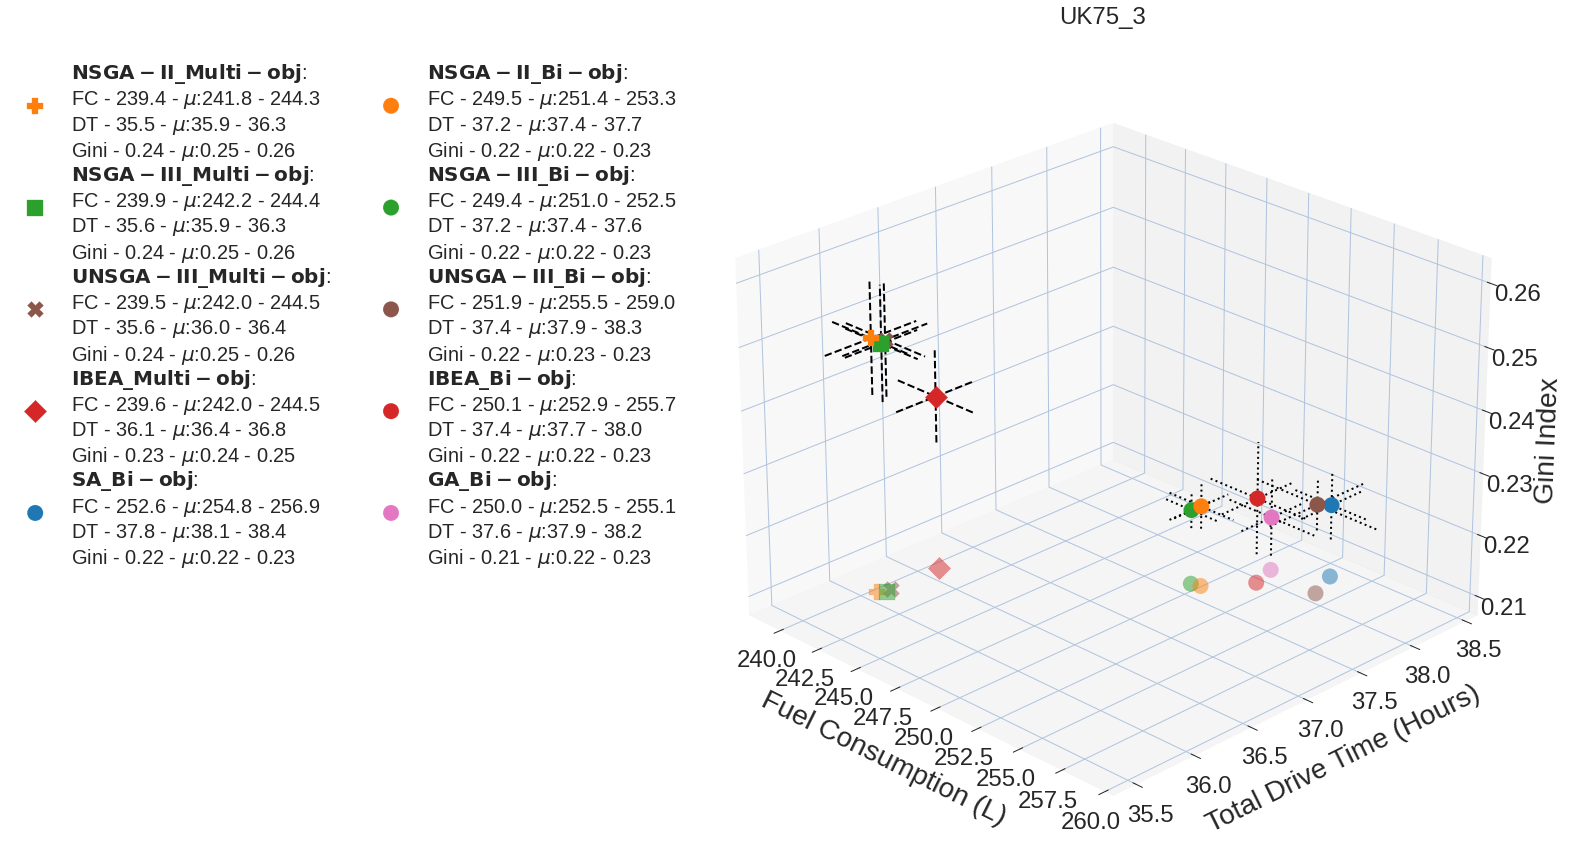

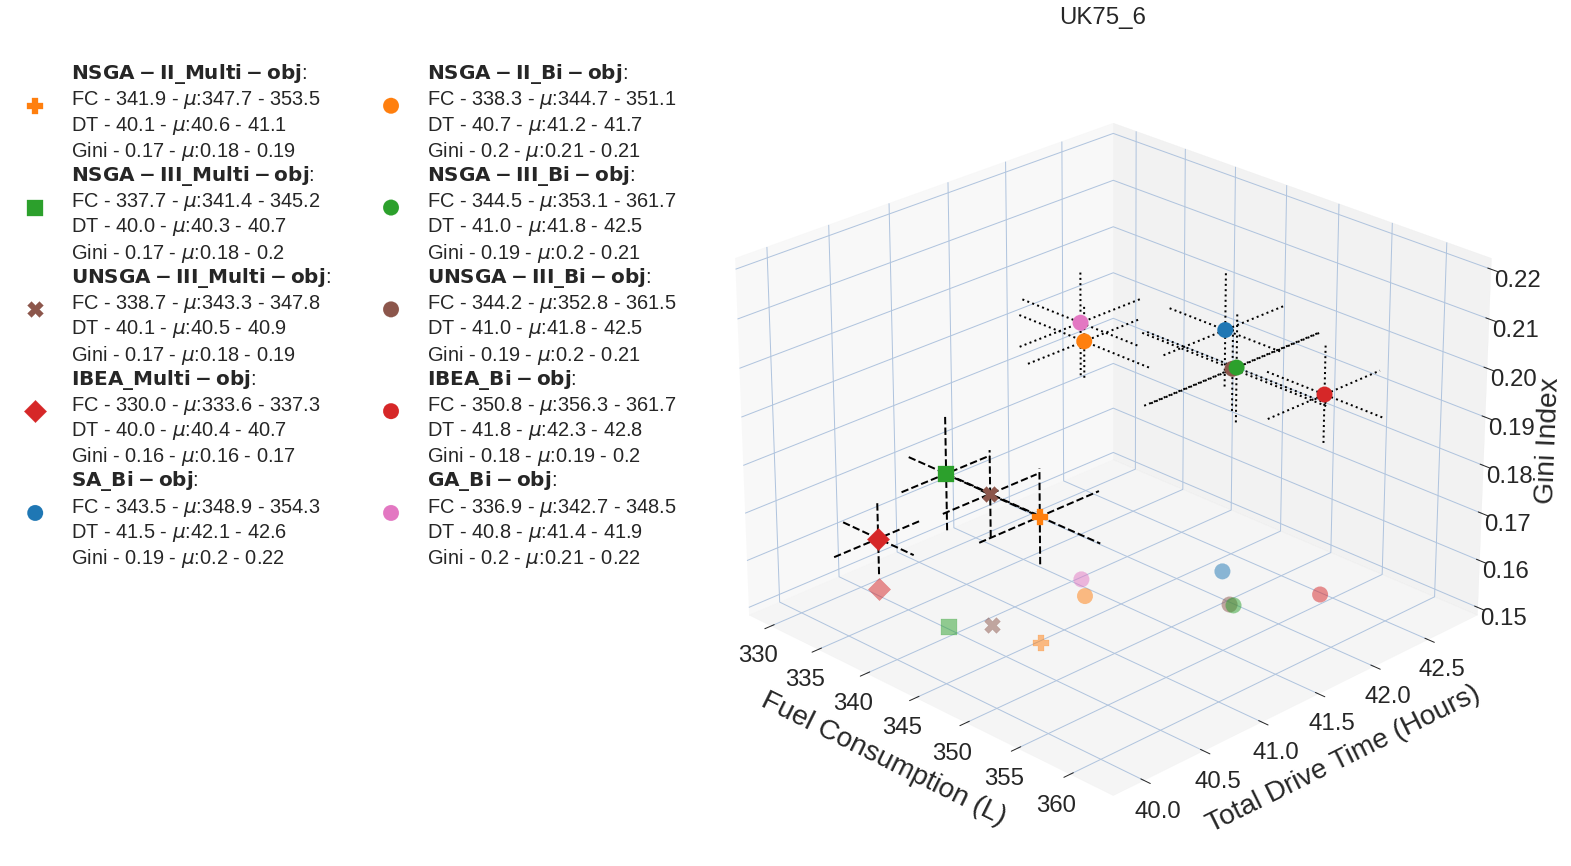

In [116]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    
    SA_bi_obj = SA_bi_objective.where(SA_bi_objective.dataset == dataset).dropna(how="all").mean()
    GA_bi_obj = GA_bi_objective.where(GA_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA2_bi_obj = NSGA2_bi_objective.where(NSGA2_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA3_bi_obj = NSGA3_bi_objective.where(NSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    UNSGA3_bi_obj = UNSGA3_bi_objective.where(UNSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    IBEA_bi_obj = IBEA_bi_objective.where(IBEA_bi_objective.dataset == dataset).dropna(how="all").mean()
    
    algorithms = [NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset,
                  SA_bi_obj,NSGA2_bi_obj,NSGA3_bi_obj,UNSGA3_bi_obj,IBEA_bi_obj,GA_bi_obj]
    
    labels = ["NSGA-II\_Multi-obj", "NSGA-III\_Multi-obj", "UNSGA-III\_Multi-obj", "IBEA\_Multi-obj","SA\_Bi-obj","NSGA-II\_Bi-obj","NSGA-III\_Bi-obj","UNSGA-III\_Bi-obj","IBEA\_Bi-obj","GA\_Bi-obj"]
    fig, ax = plot_3d_minmax(algorithms, labels,third_axis = "gini")
    plt.legend(bbox_to_anchor=(0, 1),ncol=2,handleheight=2.4, labelspacing=0.05)
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Total Drive Time (Hours)",labelpad=24)
    ax.set_zlabel("Gini Index", labelpad=16)
    ax.view_init(elev=25,azim=-45)
    #ax.view_init(elev=25,azim=-50)
    plt.title(dataset,fontsize=24)
    #plt.savefig("3d_plot_fuel_drivetime_evaluation_limited_multi_obj_{}.png".format(dataset),bbox_inches='tight')
    plt.show()

In [25]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
   
    
    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.gini_mean,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.gini_mean,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.gini_mean,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.gini_mean,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lcccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lcccc}
\toprule
{} &       NSGA-II &      NSGA-III &     UNSGA-III &          IBEA \\
\midrule
UK25\_2 & \textbf{0.06} & \textbf{0.06} &          0.07 & \textbf{0.06} \\
UK25\_4 &          0.29 & \textbf{0.28} &          0.29 &          0.30 \\
UK25\_8 & \textbf{0.06} & \textbf{0.06} &          0.07 & \textbf{0.05} \\
UK50\_1 &          0.13 &          0.13 &          0.13 & \textbf{0.11} \\
UK50\_2 &          0.10 &          0.09 & \textbf{0.11} & \textbf{0.05} \\
UK50\_4 & \textbf{0.17} & \textbf{0.17} & \textbf{0.18} & \textbf{0.17} \\
UK75\_1 &          0.19 &          0.19 & \textbf{0.18} & \textbf{0.18} \\
UK75\_3 &          0.25 &          0.25 &          0.25 & \textbf{0.24} \\
UK75\_6 & \textbf{0.18} & \textbf{0.18} & \textbf{0.18} & \textbf{0.16} \\
\bottomrule
\end{tabular}



In [26]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_bi_objective.where(NSGA2_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_bi_objective.where(NSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_bi_objective.where(UNSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_bi_objective.where(IBEA_bi_objective.dataset == dataset).dropna(how="all").mean()
   
    
    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.gini_mean,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.gini_mean,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.gini_mean,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.gini_mean,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lcccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lcccc}
\toprule
{} &       NSGA-II &      NSGA-III &     UNSGA-III &          IBEA \\
\midrule
UK25\_2 &          0.04 &          0.04 &          0.04 & \textbf{0.03} \\
UK25\_4 & \textbf{0.28} &          0.29 &          0.29 & \textbf{0.28} \\
UK25\_8 & \textbf{0.07} &          0.06 & \textbf{0.07} & \textbf{0.05} \\
UK50\_1 &          0.15 &          0.13 &          0.15 & \textbf{0.12} \\
UK50\_2 &          0.10 &          0.10 &          0.11 & \textbf{0.07} \\
UK50\_4 &          0.18 & \textbf{0.17} & \textbf{0.17} & \textbf{0.17} \\
UK75\_1 &          0.21 &          0.20 & \textbf{0.19} &          0.20 \\
UK75\_3 & \textbf{0.28} &          0.27 & \textbf{0.28} & \textbf{0.25} \\
UK75\_6 &          0.23 &          0.21 &          0.22 & \textbf{0.19} \\
\bottomrule
\end{tabular}



In [16]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.fuel_consumption_final,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.fuel_consumption_final,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.fuel_consumption_final,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.fuel_consumption_final,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lccccccc}
\toprule
{} &         NSGA-II & NSGA-III & UNSGA-III &            IBEA \\
\midrule
UK25\_2 &  \textbf{69.49} &    69.74 &     70.40 &           69.53 \\
UK25\_4 &          245.07 &   246.63 &    248.80 & \textbf{242.12} \\
UK25\_8 & \textbf{108.82} &   110.54 &    109.61 &          109.30 \\
UK50\_1 & \textbf{215.39} &   218.11 &    219.52 &          217.07 \\
UK50\_2 &          182.78 &   182.25 &    180.09 & \textbf{177.94} \\
UK50\_4 &          174.06 &   174.05 &    173.31 & \textbf{171.65} \\
UK75\_1 &          485.15 &   495.59 &    514.52 & \textbf{440.44} \\
UK75\_3 & \textbf{241.84} &   242.16 &    242.01 &          242.05 \\
UK75\_6 &          347.69 &   341.44 &    343.30 & \textbf{333.64} \\
\bottomrule
\end{tabular}



In [17]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.total_drive_time,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.total_drive_time,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.total_drive_time,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.total_drive_time,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lccccccc}
\toprule
{} &          NSGA-II &         NSGA-III &        UNSGA-III &             IBEA \\
\midrule
UK25\_2 &  \textbf{544.23} &           547.56 &           545.99 &           550.63 \\
UK25\_4 &          1189.44 &          1205.10 &          1214.75 & \textbf{1179.32} \\
UK25\_8 &  \textbf{845.62} &           856.31 &           848.37 &           857.59 \\
UK50\_1 & \textbf{1690.72} &          1704.94 &          1714.98 &          1721.08 \\
UK50\_2 &          1450.72 &          1448.94 & \textbf{1416.89} &          1434.36 \\
UK50\_4 &          1444.53 &          1445.72 & \textbf{1440.05} &          1444.56 \\
UK75\_1 &          3172.47 &          3241.96 &          3342.23 & \textbf{2970.72} \\
UK75\_3 & \textbf{2154.18} &          2156.79 &          2159.92 &          2184.77 \\
UK75\_6 &          2434.02 & \textbf{2419.04} &          2431.54 &          2422.13 \\
\bottomrule
\end{tabular}



In [18]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.vehicle_amount,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.vehicle_amount,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.vehicle_amount,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.vehicle_amount,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lccccccc}
\toprule
{} &       NSGA-II &       NSGA-III &     UNSGA-III &           IBEA \\
\midrule
UK25\_2 & \textbf{3.00} &           3.07 &          3.03 &           3.10 \\
UK25\_4 & \textbf{5.00} &           5.03 &          5.03 &           5.03 \\
UK25\_8 & \textbf{3.97} &  \textbf{3.97} & \textbf{3.97} &  \textbf{3.97} \\
UK50\_1 &          9.23 &           9.23 & \textbf{9.20} &           9.67 \\
UK50\_2 &          6.33 &           6.20 &          6.17 &  \textbf{6.07} \\
UK50\_4 &          8.00 &           8.00 & \textbf{7.97} &           8.03 \\
UK75\_1 &         10.40 &          10.53 &         10.73 &  \textbf{9.30} \\
UK75\_3 &         12.17 & \textbf{12.00} &         12.50 &          12.47 \\
UK75\_6 &         11.63 &          11.63 &         11.63 & \textbf{11.47} \\
\bottomrule
\end{tabular}



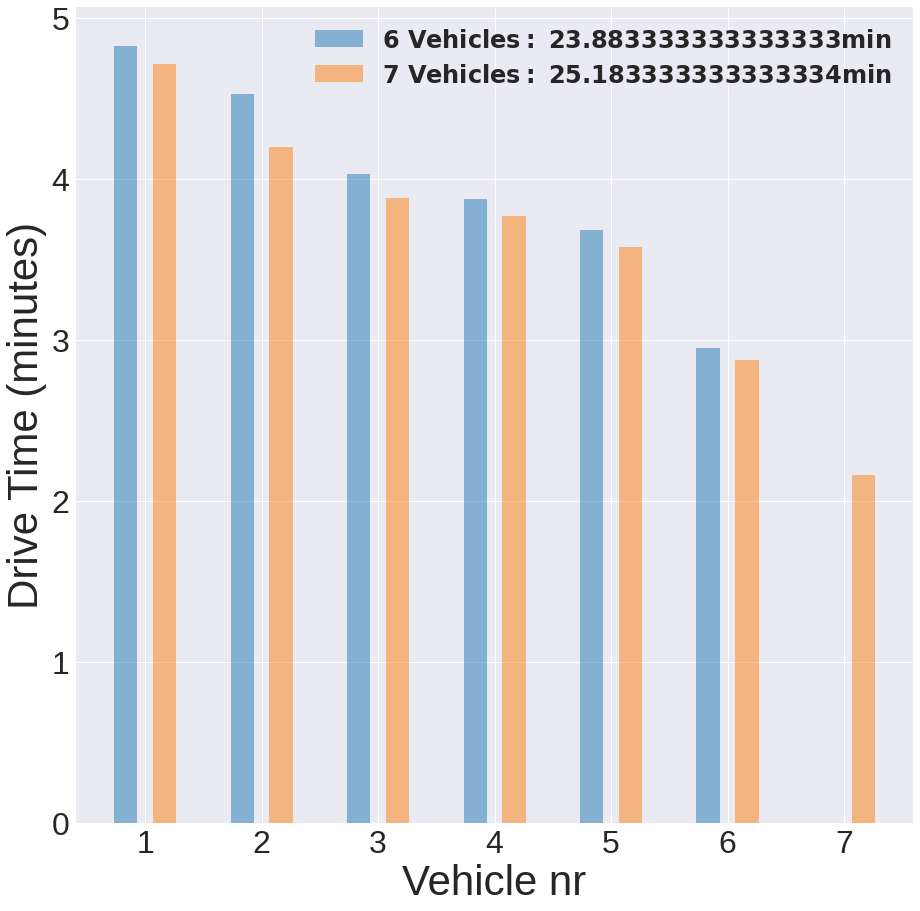

In [85]:
plot_vehicle_drivetimes(NSGA3_data_evaluation_limited,"UK50_2")

In [392]:
def euclid_3d(x,y,z):
    return(x**2 + y**2 + z**2)**0.5

In [391]:
euclid_3d(5,2,6)

65

In [396]:
def percentual_difference(x1,x2):
    return ((x1-x2)/x1) * 100

def create_result_dataframe(column):    
    dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
    #algorithm_names = [ "Best Multi-Objective","Worst Multi-Objective", "Best Bi-Objective","Worst Bi-Objective"]
    algorithm_names = [ "Best Multi-Objective","temp1", "Best Bi-Objective","temp2"]
    result_dict = {algo_name:[] for algo_name in algorithm_names}
    multi_markers = []
    bi_markers = []
    for index, dataset in enumerate(dataset_names):
        
        gini_factor = int(math.ceil(NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").fuel_consumption.iloc[0][0] / 100.0)) * 100
        
        NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
        NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
        UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
        IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
        
        NSGA2_data_dataset["name"] = "NSGA-II"
        NSGA3_data_dataset["name"] = "NSGA-III"
        UNSGA3_data_dataset["name"] = "UNSGA-III"
        IBEA_data_dataset["name"] = "IBEA"
    
        multi_obj_models = [NSGA2_data_dataset,NSGA3_data_dataset,UNSGA3_data_dataset,IBEA_data_dataset]

        #sorted_multi_obj = sorted(multi_obj_models,key = lambda model: model["fuel_consumption_final"] + model["total_drive_time"] + (model["gini_index"] * gini_factor))#model[column])
        sorted_multi_obj = sorted(multi_obj_models,key = lambda model: euclid_3d(model["fuel_consumption_final"],model["total_drive_time"],model["gini_index"]))#model[column])

        best_multi_obj,worst_multi_obj = sorted_multi_obj[::len(sorted_multi_obj)-1]


        SA_bi_obj = SA_bi_objective.where(SA_bi_objective.dataset == dataset).dropna(how="all").mean()
        GA_bi_obj = GA_bi_objective.where(GA_bi_objective.dataset == dataset).dropna(how="all").mean()
        NSGA2_bi_obj = NSGA2_bi_objective.where(NSGA2_bi_objective.dataset == dataset).dropna(how="all").mean()
        NSGA3_bi_obj = NSGA3_bi_objective.where(NSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
        UNSGA3_bi_obj = UNSGA3_bi_objective.where(UNSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
        IBEA_bi_obj = IBEA_bi_objective.where(IBEA_bi_objective.dataset == dataset).dropna(how="all").mean()
        
        
        
        
       


        SA_bi_obj["name"] = "SA"
        GA_bi_obj["name"] = "GA"
        NSGA2_bi_obj["name"] = "NSGA-II"
        NSGA3_bi_obj["name"] = "NSGA-III"
        UNSGA3_bi_obj["name"] = "UNSGA-III"
        IBEA_bi_obj["name"] = "IBEA"


        bi_obj_models = [SA_bi_obj,GA_bi_obj,NSGA2_bi_obj,NSGA3_bi_obj,UNSGA3_bi_obj,IBEA_bi_obj]
        
        sorted_bi_obj = sorted(bi_obj_models,key = lambda model: euclid_3d(model["fuel_consumption_final"],model["total_drive_time"],model["gini_index"]) )

        best_bi_obj,worst_bi_obj = sorted_bi_obj[::len(sorted_bi_obj)-1]
        div_factor = 60 if column == "total_drive_time" else 1
        
        
        
#         if np.abs(percentual_difference(best_multi_obj[column],best_bi_obj[column])) > 5:
#             if best_multi_obj[column] < best_bi_obj[column]:
#                 multi_markers.append(index)
                
#             else:
#                 bi_markers.append(index)
                
            
            
        
        
        
#         result_dict["Best Multi-Objective"].append("{} ({})".format(np.round(best_multi_obj[column]/div_factor,2),best_multi_obj["name"]))
       
#         result_dict["Best Bi-Objective"].append("{} ({})".format(np.round(best_bi_obj[column]/div_factor,2),best_bi_obj["name"]))
        
        result_dict["Best Multi-Objective"].append(np.round(best_multi_obj[column]/div_factor,2))
        result_dict["temp1"].append(" ({})".format(best_multi_obj["name"]))
       
        result_dict["Best Bi-Objective"].append(np.round(best_bi_obj[column]/div_factor,2))
        result_dict["temp2"].append(" ({})".format(best_bi_obj["name"]))
    #print(result_dict)    
    result_df = pd.DataFrame(result_dict,index=[name[:-2]  + name[-2:] for name in dataset_names ])
    
    
    
    
    return result_df


In [399]:
import re
test = create_result_dataframe("fuel_consumption_final")

min_pandas = test.min(1)
def f_tex(x):
    value = float(x[:x.index("(")])
    
    
    if value in min_pandas.values:
        return 'background-color: yellow'
    else:
        return ''

test["Best Multi-Objective"] = test["Best Multi-Objective"].astype(str) + test["temp1"]
test["Best Bi-Objective"] = test["Best Bi-Objective"].astype(str) + test["temp2"]
test= test.drop(["temp1","temp2"],axis=1)
    
test.style.applymap(f_tex)

In [400]:
import re
test = create_result_dataframe("total_drive_time")

min_pandas = test.min(1)
def f_tex(x):
    value = float(x[:x.index("(")])
    
    
    if value in min_pandas.values:
        return 'background-color: yellow'
    else:
        return ''

test["Best Multi-Objective"] = test["Best Multi-Objective"].astype(str) + test["temp1"]
test["Best Bi-Objective"] = test["Best Bi-Objective"].astype(str) + test["temp2"]
test= test.drop(["temp1","temp2"],axis=1)
    
test.style.applymap(f_tex)

In [401]:
import re
ugly_mod_val = 1
test = create_result_dataframe("gini_index")

min_pandas = test.min(1)
min_pandas = min_pandas* np.arange(1,len(min_pandas)+1,1) 


def f_tex(x):
#     global ugly_mod_val 
#     ugly_mod_val= ugly_mod_val +.5
#     value = float(x[:x.index("(")])
    
#     print(value/int(ugly_mod_val))
#     if value/int(ugly_mod_val) in min_pandas.values:

    if x in ["0.06 (NSGA-II)","0.3 (IBEA)","0.1 (IBEA)","0.11 (UNSGA-III)","0.16 (GA)","0.18 (IBEA)","0.22 (NSGA-III)","0.16 (IBEA)"]:
        return 'background-color: yellow'
    else:
        return ''

test["Best Multi-Objective"] = test["Best Multi-Objective"].astype(str) + test["temp1"]
test["Best Bi-Objective"] = test["Best Bi-Objective"].astype(str) + test["temp2"]
test= test.drop(["temp1","temp2"],axis=1)
    
test.style.applymap(f_tex)

In [379]:
min_pandas

UK25_2    0.06
UK25_4    0.60
UK25_8    0.18
UK50_1    0.40
UK50_2    0.55
UK50_4    0.96
UK75_1    1.26
UK75_3    1.76
UK75_6    1.44
dtype: float64

In [ ]:
create_result_dataframe("total_drive_time")

In [292]:
create_result_dataframe("gini_mean")

Best Multi-Objective Best Bi-Objective
UK25_2       0.06 (NSGA-II)       0.11 (IBEA)
UK25_4           0.3 (IBEA)        0.3 (IBEA)
UK25_8       0.06 (NSGA-II)         0.22 (GA)
UK50_1       0.13 (NSGA-II)        0.1 (IBEA)
UK50_2     0.11 (UNSGA-III)       0.17 (IBEA)
UK50_4     0.18 (UNSGA-III)         0.16 (GA)
UK75_1          0.18 (IBEA)         0.26 (GA)
UK75_3       0.25 (NSGA-II)   0.22 (NSGA-III)
UK75_6          0.16 (IBEA)    0.21 (NSGA-II)

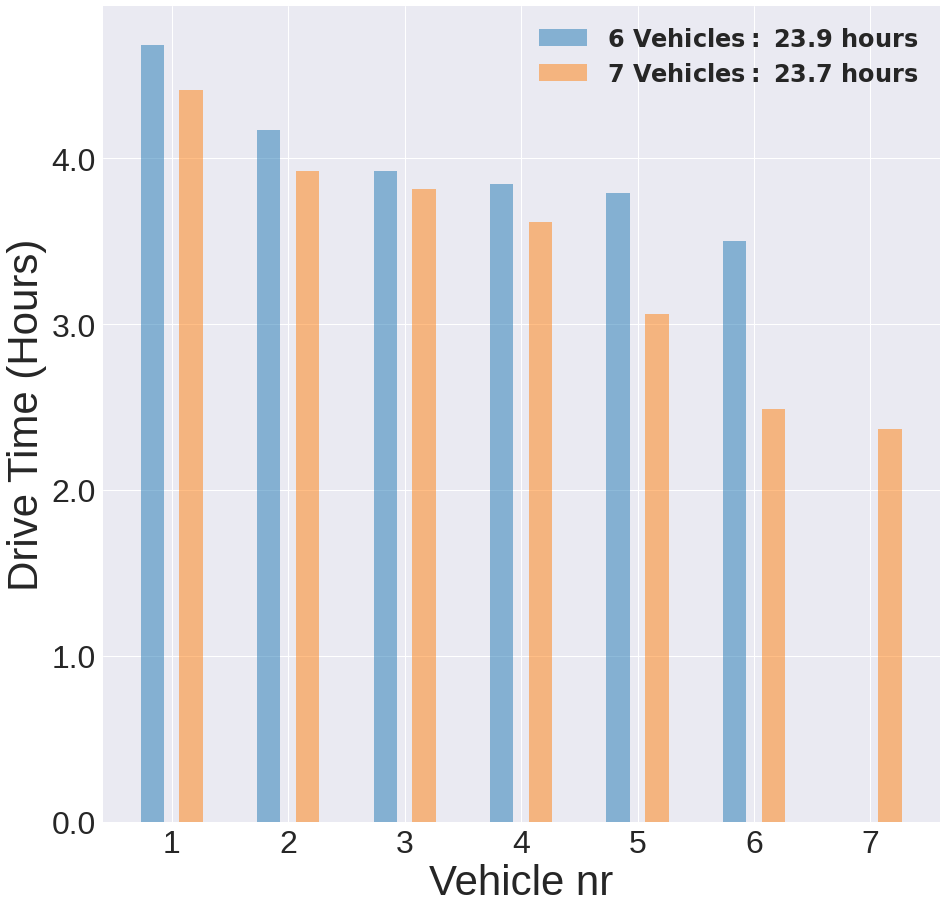

In [138]:
plot_vehicle_drivetimes(IBEA_data_evaluation_limited,"UK50_2")
plt.savefig("multi_obj_50_2_bar.png")

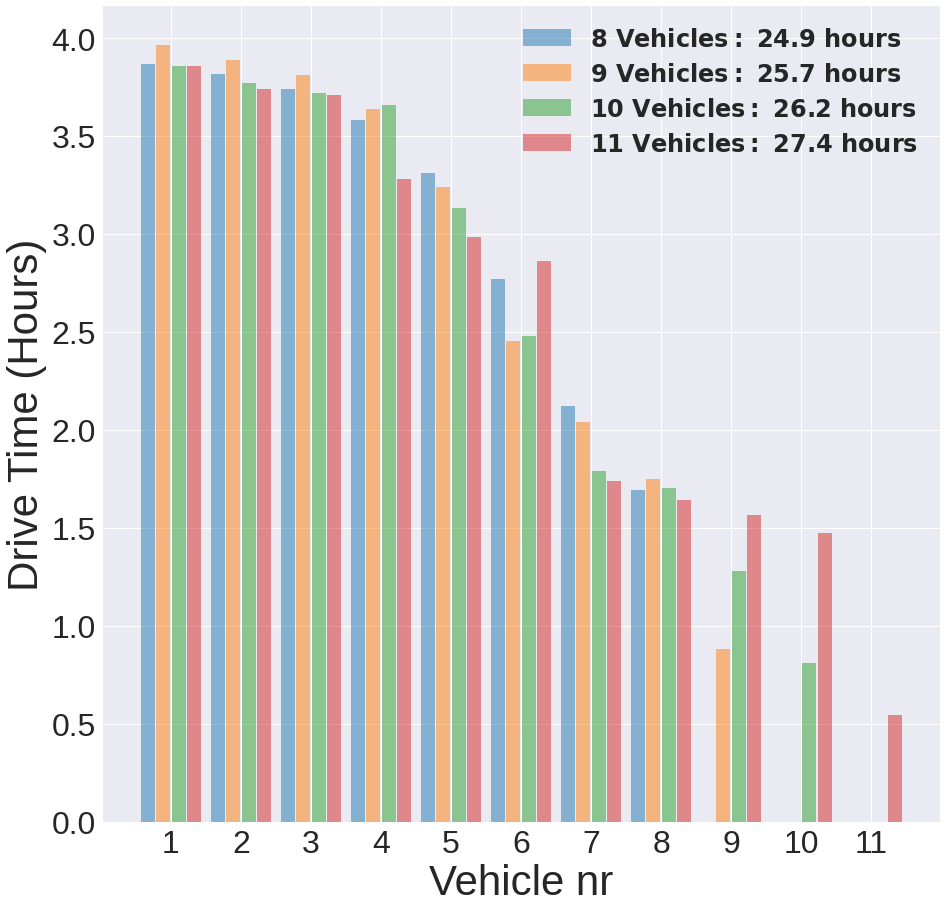

In [107]:
plot_vehicle_drivetimes(UNSGA3_bi_objective,"UK50_2")
plt.savefig("bi_obj_50_2_bar.png")

In [126]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "Best Multi-Objective","Worst Multi-Objective", "Best Bi-Objective","Worst Bi-Objective"]
result_df = {algo_name:[] for algo_name in algorithm_names}

multi_obj_vehicle_amounts = []
bi_obj_vehicle_amounts = []

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    NSGA2_data_dataset["name"] = "NSGA-II"
    NSGA3_data_dataset["name"] = "NSGA-III"
    UNSGA3_data_dataset["name"] = "UNSGA-III"
    IBEA_data_dataset["name"] = "IBEA"


    SA_bi_obj = SA_bi_objective.where(SA_bi_objective.dataset == dataset).dropna(how="all").mean()
    GA_bi_obj = GA_bi_objective.where(GA_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA2_bi_obj = NSGA2_bi_objective.where(NSGA2_bi_objective.dataset == dataset).dropna(how="all").mean()
    NSGA3_bi_obj = NSGA3_bi_objective.where(NSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    UNSGA3_bi_obj = UNSGA3_bi_objective.where(UNSGA3_bi_objective.dataset == dataset).dropna(how="all").mean()
    IBEA_bi_obj = IBEA_bi_objective.where(IBEA_bi_objective.dataset == dataset).dropna(how="all").mean()



    SA_bi_obj["name"] = "SA"
    GA_bi_obj["name"] = "GA"
    NSGA2_bi_obj["name"] = "NSGA-II"
    NSGA3_bi_obj["name"] = "NSGA-III"
    UNSGA3_bi_obj["name"] = "UNSGA-III"
    IBEA_bi_obj["name"] = "IBEA"

    multi_obj_models = [NSGA2_data_dataset,NSGA3_data_dataset,UNSGA3_data_dataset,IBEA_data_dataset]
    bi_obj_models = [SA_bi_obj,GA_bi_obj,NSGA2_bi_obj,NSGA3_bi_obj,UNSGA3_bi_obj,IBEA_bi_obj]
    
    vehicle_amount_multi_obj = np.mean([x.vehicle_amount for x in multi_obj_models])
    vehicle_amount_bi_obj = np.mean([x.vehicle_amount for x in bi_obj_models])
    
    multi_obj_vehicle_amounts.append(vehicle_amount_multi_obj)
    bi_obj_vehicle_amounts.append(vehicle_amount_bi_obj)


In [129]:
multi_obj_mean_vehicle_amount = np.array(multi_obj_vehicle_amounts).reshape((3,3)).mean(axis=1)
bi_obj_mean_vehicle_amount = np.array(bi_obj_vehicle_amounts).reshape((3,3)).mean(axis=1)

x1 = np.arange(len(multi_obj_mean_vehicle_amount))
x2 = x1+0.4


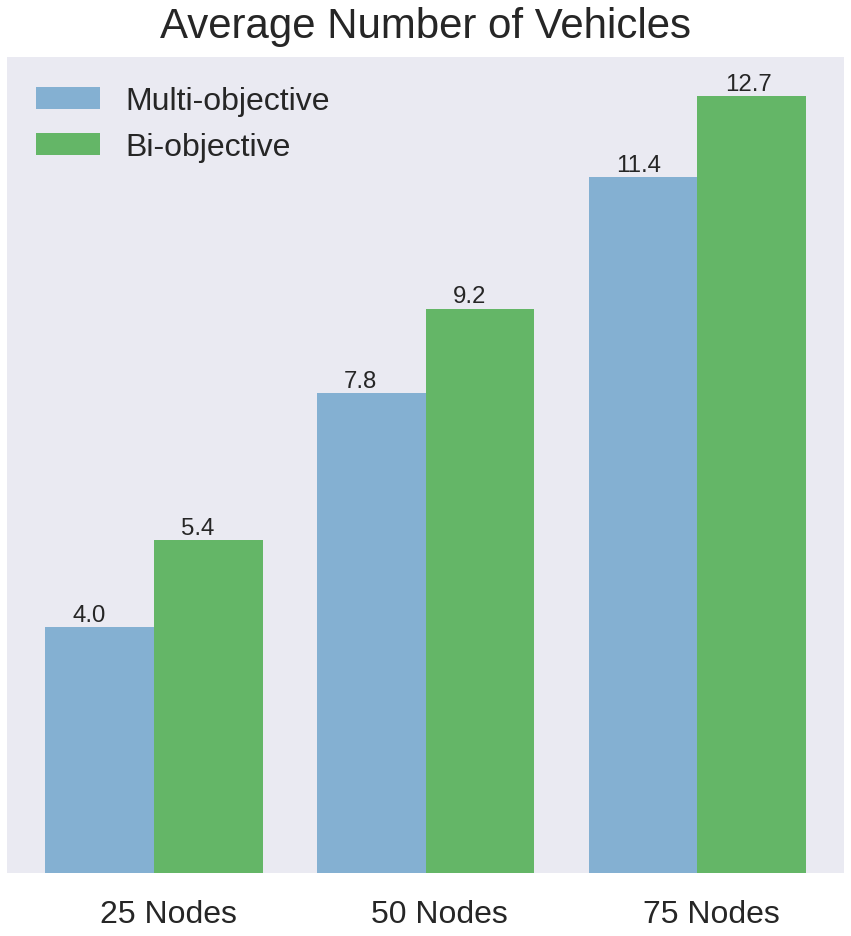

In [131]:
plt.bar(x = x1,height= multi_obj_mean_vehicle_amount,width=0.4,label="Multi-objective",alpha=0.5,color=sns.color_palette()[0])
dataset_size = [25,50,75]
for x in x1:
    offset = 0.08 if multi_obj_mean_vehicle_amount[x] - int(multi_obj_mean_vehicle_amount[x]) == 0 else 0.1
    plt.text(x-offset,multi_obj_mean_vehicle_amount[x]+0.1,round(multi_obj_mean_vehicle_amount[x],1),fontsize=24)
    plt.text(x,-.8,"{} Nodes".format(dataset_size[x]),fontsize=32)

plt.bar(x= x2 ,height = bi_obj_mean_vehicle_amount,width=0.4,label="Bi-objective",alpha=0.7,color=sns.color_palette()[2])
for x in x2:#range(len(x2)):
    offset = 0.08 if bi_obj_mean_vehicle_amount[int(x)] - int(bi_obj_mean_vehicle_amount[int(x)]) == 0 else 0.1
    plt.text(x-offset,bi_obj_mean_vehicle_amount[int(x)]+0.1,round(bi_obj_mean_vehicle_amount[int(x)],1),fontsize=24)
    
    

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
plt.legend(fontsize=32)
plt.title("Average Number of Vehicles",fontsize=42)
plt.savefig("vehicle_amount.png")